## NLP2 Project 2024-2025: Does training models with multiple labels per instance improve their ability to reproduce human variability

Welcome to the NLP2 course, and specifically this project! I hope you have fun and learn a lot! Let's get started with some basics:

**Resources**: This year, you will get access to Snellius to complete your assignment! However, be mindful that the resources are limited and hence you should be careful of how you utilise them! I would recommend that initially, you outline the experiments you want to make, you write the code for that and make sure it is free of errors/bugs (you could use Google Colab to run a small set of validation experiments before you move to Snellius) and once you are confident that everything works as it should, you can run your final experiments on Snellius. If you have not interacted with Snellius before, here are some resources you could use:



*   [Creating and Running Jobs](https://servicedesk.surf.nl/wiki/spaces/WIKI/pages/30660217/Creating+and+running+jobs)
*   [Writing a job script](https://servicedesk.surf.nl/wiki/spaces/WIKI/pages/30660220/Writing+a+job+script)
*   [Interacting with the job queue](https://servicedesk.surf.nl/wiki/spaces/WIKI/pages/30660228/Interacting+with+the+job+queue)
*   [Example job scripts](https://servicedesk.surf.nl/wiki/spaces/WIKI/pages/30660234/Example+job+scripts)



**Code:** And... onto the fun part! A script/notebook with all your code will be asked as part of your final submission. It will not be directly graded, but I should be able to reproduce all results in the paper if I run it, and understand which part of the assignment each part of the code concerns. So make sure it is relatively understandable and clean, with a few comments here and there! 😀

Some code/tools to get you started:

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import re
from collections import Counter
import random
import torch

Here, we preprocess the dataset ([Luke and Christianson, 2018](https://link.springer.com/article/10.3758/s13428-017-0908-4)) we have. It is a dataset where humans are asked to perfrom the open-cloze task, i.e. next-word prediction task. It is made of 55 passages with different styles of text from different sources. For each context in the dataset, an average of 40 participants provide which word they think follows.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# drive_base_path = '/content/drive/MyDrive/Colab Notebooks/NLP2_Project/'
# print(f"Base Drive path set to: {drive_base_path}")

Mounted at /content/drive
Base Drive path set to: /content/drive/MyDrive/Colab Notebooks/NLP2_Project/


In [ ]:
def preprocess_provo_corpus(provo):
    """Reading the raw Provo Corpus dataset and create a dictionary with all useful
    information we might need from it"""
    predict_norms = pd.read_csv(provo, sep='\t')
    paragraphs = predict_norms.groupby('Text_ID')['Text'].max()

    provo_processed = {}
    count = 0
    for text_id in range(1,56): #iterate over all provo paragraphs
        for word_num in predict_norms[predict_norms['Text_ID'] == text_id]['Word_Number'].unique(): #iterating over all words in each text
            word_dist = predict_norms[(predict_norms['Text_ID'] == text_id) & (predict_norms['Word_Number'] == word_num)]
            unique_human_words = word_dist['Response'].unique() #all human answered words for each context
            unique_word_dist = []
            for word in unique_human_words:
                unique_word_count = sum(word_dist[word_dist['Response'] == word]['Response_Count']) #getting all counts of the unique word and summing them
                unique_word_dist.append((word, unique_word_count))

            provo_processed[count] = {}
            provo_processed[count]['context_with_original_word'] = paragraphs[text_id].split(' ')[:int(word_num)]
            provo_processed[count]['context'] = paragraphs[text_id].split(' ')[:(int(word_num)-1)]
            provo_processed[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
            provo_processed[count]['human_next_word_pred'] = unique_word_dist

            count = count + 1

    return provo_processed

In [ ]:
input_data = os.path.join(os.getcwd(), 'Provo_Corpus.tsv')
data = preprocess_provo_corpus(input_data)

This is how one data point looks. You can find the original context (that was provided to participants, so that they choose a word continuation), the context with the word that was found in the original passage, the original positioning of the data point (in which paragraph it was found and the positioning of the word participants had to complete), as well as the responses from the participants (with their frequencies).  

In [ ]:
#Example of a data point
data[0]

{'context_with_original_word': ['There', 'are'],
 'context': ['There'],
 'original_positioning': {'text_id': 1, 'word_num': np.int64(2)},
 'human_next_word_pred': [('are', 16),
  ('is', 9),
  ('once', 4),
  ('will', 4),
  ('was', 3),
  ('birth', 1),
  ('comes', 1),
  ('seems', 1),
  ('were', 1)]}

### **Evaluation methodology: What do we want to improve upon?**

We have human continuation samples to a context, which we can use to obtain an estimate of the human distribution. We can also prompt a model using the same context that participants were provided with, obtain model continuations and use them to similarly obtain an estimate of the model probability distribution. Then, we can compare such distributions.

In the following cell, you can find functions that allow for obtaining distributions given samples and how you can compare them.

To obtain distributions, we use MLE estimates, where the conditional probability of a word equals its relative frequency (counting frequency of a word in a collection of samples and dividing it by the total number of samples).

In order to compare distributions, you can use any metric that can measure the 'distance' between two distributions (e.g. KL-divergence). In this project, I reccommend to use [Total Variation Distance](https://www.educative.io/answers/what-is-total-variation-tv-distance), which can be understood as a measure that quantifies the non-overlapping area between two distributions. If you have a reason to prefer another metric of statistical divergence, feel free to adjust your experiments, but remember to motivate your choice in the report.

In [ ]:
def get_estimator(elements):
    """Get the MLE estimate given all words (probability of a word equals its relative frequency)"""
    c = Counter(elements)
    support = list(c.keys())
    counts = list(c.values())
    probs = [count / sum(counts) for count in counts]

    return (support, probs)

def get_common_support(support1, support2):
    """Receives supports from two distributions and return all elements appearing in at least one of them"""
    return set(support1).union(set(support2))

def change_support(old_support, old_probs, new_support):
    """Create new support by adding elements to a support that did not exist before
     (hence, their probability value is 0)"""
    new_probs = []
    for item in new_support:
        if item in old_support:
            ind = old_support.index(item)
            new_probs.append(old_probs[ind])
        else:
            new_probs.append(0)
    return list(new_support), new_probs

def get_tvd(probs1, probs2):
    """Receives the probabilities of 2 distributions to compare and returns their TVD (Total Variation Distance)"""
    tvd = np.sum(np.abs(np.array(probs1) - np.array(probs2)))/2
    return tvd

We can compare human and model distributions and compare them using TVD. But how do we know what is a lower bound on the disagreement we can expect between models and humans?
Comparing two different/disjoing groups of humans can help us with getting a lower bound. Since we don't have data for a second group of humans, we can simulate this by randomly splitting the samples available to us in two disjoint sets. When comparing the two, one is used as a target, and the other one as an oracle model.

The next cell contains code on how you can obtain such oracles:

In [ ]:
def get_oracle_elements(words):
    """We receive a list of words and we create two disjoint subsets
    from it by sampling without replacement from them.
    We return the two disjoint sets of words"""

    #if the length of the list is odd, we remove one element at random to make the list even,
    #to ensure the two disjoint subsets are of equal length
    if (len(words) % 2 == 1):
        remove_word = random.sample(words, 1)
        words.remove(remove_word[0])

    #We sample the words that will belong in the first subset and create the second subset by removing
    #from the full word list the ones sampled in the first subset
    subset1 = random.sample(words, len(words)//2)
    subset2 = words.copy()
    for item in subset1:
        subset2.remove(item)

    return subset1, subset2

There follows an example of how you can obtain and compare distributions (in this case, between an oracle 'target' and oracle 'model')

In [ ]:
#Remeber the data point example we have already looked at
data[0]['human_next_word_pred']

[('are', 16),
 ('is', 9),
 ('once', 4),
 ('will', 4),
 ('was', 3),
 ('birth', 1),
 ('comes', 1),
 ('seems', 1),
 ('were', 1)]

In [ ]:
l_words = [[item[0]]*int(item[1]) for item in data[0]['human_next_word_pred']]
l_words = [item for row in l_words for item in row]

#We create the oracles by splitting human samples
oracle1, oracle2 = get_oracle_elements(l_words)

In [ ]:
print(oracle1)

['are', 'are', 'are', 'was', 'is', 'are', 'are', 'are', 'are', 'is', 'was', 'is', 'are', 'is', 'is', 'once', 'is', 'will', 'will', 'was']


In [ ]:
#Get the MLE estimates given the samples
support_or1, probs_or1 = get_estimator(oracle1)
support_or2, probs_or2 = get_estimator(oracle2)

In [ ]:
print(support_or1, probs_or1)
print(support_or2, probs_or2)

['are', 'was', 'is', 'once', 'will'] [0.4, 0.15, 0.3, 0.05, 0.1]
['are', 'is', 'once', 'will', 'birth', 'comes', 'seems', 'were'] [0.4, 0.15, 0.15, 0.1, 0.05, 0.05, 0.05, 0.05]


In [ ]:
#Create a new distribution support that includes all elements from both distributions
#and update each distribution accordingly
common_support = get_common_support(support_or1, support_or2)

support_or1, probs_or1 = change_support(support_or1, probs_or1, common_support)
support_or2, probs_or2 = change_support(support_or2, probs_or2, common_support)

In [ ]:
print(support_or1, probs_or1)
print(support_or2, probs_or2)

['is', 'were', 'birth', 'was', 'once', 'comes', 'are', 'will', 'seems'] [0.3, 0, 0, 0.15, 0.05, 0, 0.4, 0.1, 0]
['is', 'were', 'birth', 'was', 'once', 'comes', 'are', 'will', 'seems'] [0.15, 0.05, 0.05, 0, 0.15, 0.05, 0.4, 0.1, 0.05]


In [ ]:
#Finally, measure their TVD
get_tvd(probs_or1, probs_or2)

np.float64(0.30000000000000004)

In a similar fashion, you can compare human and model conditional probability distributions; by using human and model samples, obtaining their MLE estimates and compare them using TVD. You need to do that for model samples generated before and after fine-tuning -- to assess the effect of multi-label supervising.

### **Research Question 1(a): Small LM fine-tuning**

Importing the model you will need to fine-tune (and take samples to obtain a conditional probability distribution). If you'd like to use another model, this is allowed (but make sure to motivate your choices in the report)

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

In [ ]:
#Switching to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Make sure type='cuda'
device

device(type='cuda')

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizer.pad_token

'<|endoftext|>'

How to obtain unbiased samples from the model:

In [ ]:
def get_model_samples(model, tokenizer, context, n_samples = 5, add_tokens = 5, top_k = 0, pad_token = "<|endoftext|>"):
    """Given a context we return the words that were generated during ancestral sampling for n_samples"""
    tokenized_inputs = tokenizer(context, return_tensors="pt") # Get the full output dict
    inputs_ids = tokenized_inputs['input_ids'].to(device)
    attention_mask = tokenized_inputs['attention_mask'].to(device) # Get attention_mask and send to device

    #This samples unbiasedly from the next-token distribution of the model for add_tokens tokens, n_samples times
    # outputs = model.generate(inputs_ids, attention_mask = attention_mask, pad_token_id = tokenizer.eos_token_id, do_sample=True, num_beams = 1, num_return_sequences= n_samples,
                            #  max_new_tokens = add_tokens, pad_token = tokenizer.pad_token, top_k= top_k)
    outputs = model.generate(inputs_ids, attention_mask = attention_mask, pad_token_id = tokenizer.eos_token_id, do_sample=True, num_beams = 1, num_return_sequences= n_samples,
                             max_new_tokens = add_tokens)

    outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    #Remove context to keep only generated text
    outputs = [x.replace(context + ' ', '').replace(context, '').replace('\n', '') for x in outputs]
    #Remove punctuation
    outputs = [re.sub(r'[^\w\s]', '', x) for x in outputs] #removing punctuation
    list_of_words = [x.split(' ') for x in outputs]

    sampled_words = []
    for generation in list_of_words:
        if set(generation) == {''}:
            sampled_words.append('Failed to generate word')
        else:
            sampled_words.append(next(x.lower() for x in generation if x))

    return sampled_words

In [ ]:
context = data[0]['context'][0]

In [ ]:
model_samples = get_model_samples(model, tokenizer, context, n_samples = 40)
#Remove samples for which we failed to generate a complete word
model_samples = [x for x in model_samples if x != 'Failed to generate word']
print(model_samples)

['he', 'were', 'how', 'i', 'like', 'theres', 'oneb', 'and', 'now', 'a', 'weve', 'and', 'thats', 'a', 'is', 'so', 'nono', 'a', 'have', 'could', 'are', 'of', 'that', 'mr', 'its', 'a', 'have', 'to', 'the', 'have', 'hes', 'i', 's', 'to', 'the', 'to', 'would', 'also', 'also', 'was']


*Mind that here we used n_samples=40. Previous empirical evidence shows that this number is sufficient, so this number would be fine to use for all your experiments.*

In [ ]:
human_samples = l_words.copy()

In [ ]:
support_human, probs_human = get_estimator(human_samples)
support_model, probs_model = get_estimator(model_samples)

common_support = get_common_support(support_human, support_model)

support_human, probs_human = change_support(support_human, probs_human, common_support)
support_model, probs_model = change_support(support_model, probs_model, common_support)

get_tvd(probs_human, probs_model)

For this instance, the model and human distributions had a TVD of 0.625; for the same instance, the TVD between oracles was 0.300. In this case, the model predicted a conditional probability distribution that deviated more from the target than the oracle did.

***RQ1: Will this change when we fine-tune our model?***

You need to assess such values accross a collection of (***held-out***) instances/contexts to assess this matter better. The held-out refers to contexts that were not used at the fine-tuning stage.

***Some tips for fine-tuning:***
- It's likely that the most important aspect of the fine-tuning is to ensure that your model will encounter variability, per context. There might be a few ways to go around this (e.g. how you construct the fine-tuning dataset or how you design your optimising loss etc.). Think about this well and feel free to discuss this with me during one of the labs.
- We have a quite small dataset, so consider using k-fold cross validation ([here](https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right) is an introductory tutorial). When you design this, remember: you will need a held-out set for validating the fine-tuning and a held-out set for assessing how well the model predicts human variability. Additionally, make sure you think well and motivate how these should be created (e.g. should *paragraphs* that appear in training also appear in a test set?).
- Again, our fine-tuning dataset is very small. This might mean that fine-tuning extensively on it, might not only overfit on it, but have a catastropic forgetting effect on the model. Considering that, as well as the fact that you might have limited computational resources, you might find it helpful to use techniques that only fine-tune only a subset of the model parameters (by using [layer freezing](https://ar5iv.labs.arxiv.org/html/1911.03090)) or by only optimising a small number of additional parameters, while keeping the original model weights unchanged ([Parameter efficient prompt tuning](https://arxiv.org/pdf/2104.08691v2.pdf)). You might find that such a method is not necessary, but you still might want to investigate this (e.g. as part of RQ3).

In [ ]:
#ENTER CODE
#Fine-tune experiments here

Below is all the code for fine-tuning the models. However, if you do not want to retrain the models, you can save them in your drive and load them like this (do change the directory to the specified path).

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# drive_base_path = '/content/drive/MyDrive/Colab Notebooks/NLP2_Project/'
# print(f"Base Drive path set to: {drive_base_path}")


Mounted at /content/drive
Base Drive path set to: /content/drive/MyDrive/Colab Notebooks/NLP2_Project/


In [ ]:
# # First, load both models. We will do the analaysis with seed 123
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token

# # Define model paths using the drive_base_path
# non_ft_model_path = os.path.join(drive_base_path, 'models/gpt2_seed_123')
# ft_model_path = os.path.join(drive_base_path, 'models/fine_tuned_gpt2_seed_123')
# ft_model_path_ht = os.path.join(drive_base_path, 'models/fine_tuned_ht_gpt2_seed_123')

# # Load non-fine-tuned model
# model_non_ft = GPT2LMHeadModel.from_pretrained(non_ft_model_path)
# model_non_ft.to(device)

# # Load fine-tuned model from saved path
# model_ft = GPT2LMHeadModel.from_pretrained(ft_model_path)
# model_ft.to(device)

# # Load fine-tuned model with cross-entropy loss from saved path
# model_ft_ht = GPT2LMHeadModel.from_pretrained(ft_model_path_ht)
# model_ft_ht.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# import csv
# import ast
# import re

# def parse_tvd_list_string(s):
#     """
#     Parses a string representation of a list of np.float64 values
#     e.g., "[np.float64(0.1), np.float64(0.2)]" into a list of floats [0.1, 0.2].
#     """
#     if not s or s == '[]': # Handle empty or empty-list strings
#         return []
#     # Remove "np.float64(" and ")" using regex to get the number
#     cleaned_s = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)
#     try:
#         # ast.literal_eval safely evaluates a string containing a Python literal
#         return ast.literal_eval(cleaned_s)
#     except (ValueError, SyntaxError) as e:
#         print(f"Error parsing string. Cleaned string: '{cleaned_s}'. Original part: '{s}'. Error: {e}")
#         return [] # Return empty list or raise error, depending on desired handling

# csv_file_path = os.path.join(drive_base_path, 'results/tvd_results.csv')

# # Initialize dictionaries to store the scores
# tvd_scores_non_fine_tuned = {}
# tvd_scores_fine_tuned = {}
# #tvd_scores_fine_tuned_ht = {}
# #tvd_scores_oracle = {}

# mean_tvd_non_fine_tuned = []
# mean_tvd_fine_tuned = []
# #mean_tvd_fine_tuned_ht = []
# #mean_oracle_tvd = []

# try:
#     with open(csv_file_path, mode='r', newline='') as file:
#         reader = csv.DictReader(file)
#         for row in reader:
#             try:
#                 seed = int(row['Seed'])

#                 # Load mean TVD values into lists
#                 mean_tvd_non_fine_tuned.append(float(row['Mean TVD Non-Fine-Tuned']))
#                 mean_tvd_fine_tuned.append(float(row['Mean TVD Fine-Tuned']))
#                 #mean_tvd_fine_tuned_ht.append(float(row['Mean TVD Fine-Tuned HT']))
#                 #mean_oracle_tvd.append(float(row['Oracle TVD']))

#                 # Load full TVD scores (lists of TVD values)
#                 tvd_scores_non_fine_tuned[seed] = parse_tvd_list_string(row['Full TVD Non-Fine-Tuned'])
#                 tvd_scores_fine_tuned[seed] = parse_tvd_list_string(row['Full TVD Fine-Tuned'])
#                 #tvd_scores_fine_tuned_ht[seed] = parse_tvd_list_string(row['Full TVD Fine-Tuned HT'])
#                 #tvd_scores_oracle[seed] = parse_tvd_list_string(row['Full TVD Oracle'])
#             except KeyError as e:
#                 print(f"Error: Missing column {e} in CSV file for row: {row}")
#             except ValueError as e:
#                 print(f"Error converting data for seed {row.get('Seed', 'Unknown')}: {e}. Row: {row}")

# except FileNotFoundError:
#     print(f"Error: The file {csv_file_path} was not found.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")


### Fine-tuning GPT-2

Split on paragraph level to ensure the train/test sets do not have data from the same paragraphs

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np


all_paragraph_ids = sorted(list(set(data[key]['original_positioning']['text_id'] for key in data)))
print(f"Total unique paragraphs: {len(all_paragraph_ids)}")

train_val_paragraph_ids, test_paragraph_ids = train_test_split(
    all_paragraph_ids,
    test_size=0.2,
    random_state=42
)

train_paragraph_ids, val_paragraph_ids = train_test_split(
    train_val_paragraph_ids,
    test_size=0.1,  # 10% of the 80%
    random_state=42
)

print(f"Number of paragraphs in train set: {len(train_paragraph_ids)}")
print(f"Number of paragraphs in validation set: {len(val_paragraph_ids)}")
print(f"Number of paragraphs in test set: {len(test_paragraph_ids)}")

train_paragraph_ids_set = set(train_paragraph_ids)
val_paragraph_ids_set = set(val_paragraph_ids)
test_paragraph_ids_set = set(test_paragraph_ids)

train_data = {}
val_data = {}
test_data = {}

for key, sample in data.items():
    paragraph_id = sample['original_positioning']['text_id']
    if paragraph_id in train_paragraph_ids_set:
        train_data[key] = sample
    elif paragraph_id in val_paragraph_ids_set:
        val_data[key] = sample
    elif paragraph_id in test_paragraph_ids_set:
        test_data[key] = sample

print(f"\nNumber of contexts in train_data: {len(train_data)}")
print(f"Number of contexts in val_data: {len(val_data)}")
print(f"Number of contexts in test_data: {len(test_data)}")

Total unique paragraphs: 55
Number of paragraphs in train set: 39
Number of paragraphs in validation set: 5
Number of paragraphs in test set: 11

Number of contexts in train_data: 1893
Number of contexts in val_data: 258
Number of contexts in test_data: 536

Overlap in paragraph IDs between train and val: 0
Overlap in paragraph IDs between train and test: 0
Overlap in paragraph IDs between val and test: 0
Paragraph-level split successful: No overlap in paragraph IDs between sets.
Total original contexts: 2687
Total assigned contexts after split: 2687

Sample paragraph IDs in train set: [1, 3, 4, 5, 7]
Sample paragraph IDs in val set: [2, 41, 21, 55, 23]
Sample paragraph IDs in test set: [32, 33, 6, 42, 44]


In [ ]:
import string
def maybe_add_space(w):
    return " " + w if w and w[0] not in string.punctuation else w

In [ ]:
def word_level_loss(model, tokenizer, sample, device, soft_target=True):
    """
    Compute loss for one sample.
    If soft_target is True: -sum_w p_human(w|c) * log q_model(w|c)
    If soft_target is False: -log q_model(w_dominant|c)

    Args:
      model        : a GPT-2 LM with .past_key_values support
      tokenizer    : the corresponding HuggingFace tokenizer
      sample       : dict with keys
                       - "context": List[str]
                       - "human_next_word_pred": List[(word:str, count:int)]
      device       : torch device
      soft_target  : bool, if True use human distribution, if False use dominant word as one-hot.

    Returns:
      loss         : scalar Tensor on `device`
    """
    raw_pairs = sample["human_next_word_pred"]

    if not raw_pairs:
        return torch.tensor(0.0, device=device, requires_grad=True)

    processed_pairs = []
    for w, cnt in raw_pairs:
        if pd.isna(w):
            continue
        s_w = str(w).strip()
        if not s_w:
            continue
        try:
            valid_count = int(cnt)
            if valid_count < 0:
                valid_count = 0
        except (ValueError, TypeError):
            valid_count = 0
        processed_pairs.append((s_w, valid_count))

    processed_pairs = [pair for pair in processed_pairs if pair[1] > 0]

    if not processed_pairs:
        return torch.tensor(0.0, device=device, requires_grad=True)

    target_words_tuple = tuple()
    pvec = torch.empty(0, device=device, dtype=torch.float32)

    if soft_target:
        total_count = sum(cnt for _, cnt in processed_pairs)
        if total_count <= 0:
            return torch.tensor(0.0, device=device, requires_grad=True)

        words_list, pw_list = zip(*[(w, cnt / total_count) for w, cnt in processed_pairs])
        target_words_tuple = tuple(words_list)
        pvec = torch.tensor(pw_list, device=device, dtype=torch.float32)
    else: # Hard target (majority vote)
        # Find dominant word
        dominant_word_tuple = max(processed_pairs, key=lambda item: item[1])
        dominant_word_str = dominant_word_tuple[0]
        target_words_tuple = (dominant_word_str,)
        pvec = torch.tensor([1.0], device=device, dtype=torch.float32)

    if not target_words_tuple:
        return torch.tensor(0.0, device=device, requires_grad=True)

    ctx = " ".join(sample["context"])
    if not ctx.strip() and not target_words_tuple:
        return torch.tensor(0.0, device=device, requires_grad=True)

    enc = tokenizer(ctx, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}

    if enc['input_ids'].numel() == 0 and not ctx.strip(): # Context was empty and tokenized to nothing
        pass


    out_ctx = model(**enc, use_cache=True)
    past = out_ctx.past_key_values

    if out_ctx.logits.shape[1] == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)

    cands_with_space = [maybe_add_space(w) for w in target_words_tuple]

    valid_cands_with_space = []
    valid_pvec_indices = []
    temp_pvec_list = []

    for i, cand_w_space in enumerate(cands_with_space):
        if tokenizer.encode(cand_w_space, add_special_tokens=False):
            valid_cands_with_space.append(cand_w_space)
            valid_pvec_indices.append(i)
            if soft_target or (not soft_target and i==0):
                 temp_pvec_list.append(pvec[i].item())

    if not valid_cands_with_space:
        return torch.tensor(0.0, device=device, requires_grad=True)

    if soft_target:
        pvec = torch.tensor(temp_pvec_list, device=device, dtype=torch.float32)
        if pvec.sum() > 0 and pvec.sum() != 1.0:
             pvec = pvec / pvec.sum()
        elif pvec.sum() == 0 and len(pvec) > 0 :
             return torch.tensor(0.0, device=device, requires_grad=True)


    cand_tokens = tokenizer(valid_cands_with_space,
                            return_tensors="pt",
                            padding=True,
                            add_special_tokens=False)
    cand_tokens = {k: v.to(device) for k, v in cand_tokens.items()}
    input_ids      = cand_tokens["input_ids"]
    K, L_max       = input_ids.shape

    if K == 0:
        return torch.tensor(0.0, device=device, requires_grad=True)

    past_batched = [
        (k_past.repeat(K, 1, 1, 1), v_past.repeat(K, 1, 1, 1))
        for (k_past, v_past) in past
    ]

    # log P(w_0 | c)
    logp_ctx = F.log_softmax(out_ctx.logits[0, -1, :], dim=-1)
    first_ids      = input_ids[:, 0]
    logq_first_sub = logp_ctx.gather(0, first_ids)

    # sum over the suffix tokens
    logq_suffix = torch.zeros(K, device=device, dtype=logq_first_sub.dtype)
    if L_max > 1:
        in_ids_suffix  = input_ids[:, :-1]
        tgt_ids_suffix = input_ids[:, 1:]

        if in_ids_suffix.shape[1] > 0:
            out_suf = model(input_ids=in_ids_suffix,
                            past_key_values=past_batched,
                            use_cache=True)
            logp_suf = F.log_softmax(out_suf.logits, dim=-1)
            logq_suf = logp_suf.gather(-1, tgt_ids_suffix.unsqueeze(-1)).squeeze(-1)

            # Create mask for padding tokens in the target
            mask     = (tgt_ids_suffix != tokenizer.pad_token_id)
            logq_suffix = (logq_suf * mask).sum(dim=-1)

    # total log-prob per word
    logq = logq_first_sub + logq_suffix

    # cross-entropy
    pvec = pvec.to(logq.dtype)
    loss = -(pvec * logq).sum()

    if torch.isnan(loss) or torch.isinf(loss):
        return torch.tensor(0.0, device=device, requires_grad=True)

    return loss

In [ ]:
from tqdm.auto import tqdm
import torch.nn.functional as F

def train(model, optimizer, train_data, val_data, tokenizer, device, mb_size=16, epochs=1, soft_target=True):
    train_losses = []
    val_losses = []
    batch_loss = 0.0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} ")
        model.train()
        total_train_loss = 0.0
        batch_count = 0

        # Shuffle the training data for the current epoch
        train_data_items = list(train_data.items())
        random.shuffle(train_data_items)

        for step, (ctx_id, sample) in tqdm(enumerate(train_data.items(), start=1), total=len(train_data), desc=f"Epoch {epoch+1} [TRAIN]"):
            loss = word_level_loss(model, tokenizer, sample, device, soft_target=soft_target)

            total_train_loss += loss.item()
            batch_loss += loss
            batch_count += 1

            if batch_count == mb_size or step == len(train_data):
                # average loss over the batch
                batch_loss /= batch_count

                optimizer.zero_grad(set_to_none=True)
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                # reset batch accumulators
                batch_loss  = torch.zeros((), device=device)
                batch_count = 0

        avg_train = total_train_loss / len(train_data)
        train_losses.append(avg_train)
        print(f"  → train_loss = {avg_train:.4f}")

        # Validation loop
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for sample in tqdm(
                val_data.values(),
                total=len(val_data),
                desc=f"  [ VAL ]"
            ):
                vloss = word_level_loss(model, tokenizer, sample, device, soft_target=soft_target)
                total_val_loss += vloss.item()

        avg_val = total_val_loss / len(val_data)
        val_losses.append(avg_val)
        print(f"  → val_loss   = {avg_val:.4f}")

    return train_losses, val_losses


In [ ]:
def evaluate_model_tvd(model, tokenizer, test_data, device):
    """
    Evaluate the model using Total Variation Distance (TVD) on the test data.
    """
    tvd_scores = []
    for idx, (key, sample_data) in enumerate(list(test_data.items())):
        # Get context and next word predictions
        context_list = sample_data['context']
        context = ' '.join(context_list)
        next_word_preds = sample_data['human_next_word_pred']

        # Generate model samples
        model_samples = get_model_samples(model, tokenizer, context, n_samples=40)
        model_samples = [x for x in model_samples if x != 'Failed to generate word']
        # print(f"Model samples for test data point {idx}: {model_samples}")

        # Get human samples
        l_words = [[item[0]]*int(item[1]) for item in next_word_preds]
        human_samples = [item for row in l_words for item in row]
        # print(f"Human samples for test data point {idx}: {human_samples}")
        # human_samples = [item[0] for item in next_word_preds]

        # Get MLE estimates
        support_human, probs_human = get_estimator(human_samples)
        support_model, probs_model = get_estimator(model_samples)

        # Create common support
        common_support = get_common_support(support_human, support_model)

        # Change support
        support_human, probs_human = change_support(support_human, probs_human, common_support)
        support_model, probs_model = change_support(support_model, probs_model, common_support)

        # Calculate TVD
        tvd = get_tvd(probs_human, probs_model)
        # print(f"TVD for test data point {idx}: {tvd}")
        tvd_scores.append(tvd)

    return tvd_scores



In [ ]:
import matplotlib.pyplot as plt

def plot_tvd_scores(tvd_scores, model='Fine-Tuned'):
    """
    Plot the TVD scores in a histogram.
    """
    tvd_scores_cleaned = [s for s in tvd_scores if pd.notna(s)]
    mean_tvd = np.mean(tvd_scores_cleaned) if tvd_scores_cleaned else None
    print(f"Mean TVD: {mean_tvd}")

    # Plot TVD scores in a histogram
    if tvd_scores_cleaned:
        plt.hist(tvd_scores_cleaned, bins=20, edgecolor='black')
        plt.title(f"Histogram of TVD Scores ({model} Model vs. Human)")
        plt.xlabel("Total Variation Distance (TVD)")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No TVD scores to plot.")


### Multiple seed training and Evaluation

In [ ]:
# Plot TVD scores for both models and oracle in same figure with different colors and opacities
def plot_tvd_scores_comparison(tvd_scores_non_fine_tuned, tvd_scores_fine_tuned, oracle_tvd_scores):
    """
    Plot the TVD scores for both models in a histogram.
    """
    tvd_scores_non_fine_tuned_cleaned = [s for s in tvd_scores_non_fine_tuned if pd.notna(s)]
    tvd_scores_fine_tuned_cleaned = [s for s in tvd_scores_fine_tuned if pd.notna(s)]
    oracle_tvd_scores_cleaned = [s for s in oracle_tvd_scores if pd.notna(s)]

    color_nft = 'C0'
    color_ft = 'C1'
    color_or = 'C2'

    plt.hist(tvd_scores_non_fine_tuned_cleaned, bins=20, alpha=0.5, label='Non-Fine-Tuned Model',
             color=color_nft, edgecolor=color_nft, hatch='\\')
    plt.hist(tvd_scores_fine_tuned_cleaned, bins=20, alpha=0.5, label='Fine-Tuned Model',
             color=color_ft, edgecolor=color_ft, hatch='o')
    plt.hist(oracle_tvd_scores_cleaned, bins=20, alpha=0.5, label='Oracle',
             color=color_or, edgecolor=color_or, hatch='//')

    plt.title("Histogram of TVD Scores (Non-Fine-Tuned vs. Fine-Tuned Model vs. Oracle)")
    plt.xlabel("Total Variation Distance (TVD)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.savefig("tvd_scores_comparison.pdf")
    plt.show()


Non fine-tuned

In [ ]:
seeds = [42, 123, 456]

In [ ]:
tvd_scores_non_fine_tuned = {}
mean_tvd_non_fine_tuned = []

for seed in seeds:
    print(f"----- Starting Seed {seed} -----")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    current_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    current_model.to(device)
    current_model.eval()
    tokenizer.pad_token

    current_model.save_pretrained(f"./gpt2_seed_{seed}")
    tokenizer.save_pretrained(f"./gpt2_seed_{seed}")

    # Evaluate non-fine-tuned model
    tvd_scores_non_fine_tuned[seed] = evaluate_model_tvd(current_model, tokenizer, test_data, device)
    mean_tvd_non_fine_tuned.append(np.mean(tvd_scores_non_fine_tuned[seed]))
    print(f"Mean TVD for seed {seed}: {mean_tvd_non_fine_tuned[-1]}")


----- Starting Seed 42 -----
Mean TVD for seed 42: 0.6077645449035649
----- Starting Seed 123 -----
Mean TVD for seed 123: 0.6071584462963575
----- Starting Seed 456 -----
Mean TVD for seed 456: 0.6063666923146404


Fine-tuned

In [ ]:
tvd_scores_fine_tuned = {}
mean_tvd_fine_tuned = []
for seed in seeds:
    print(f"----- Starting Seed {seed} -----")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Re-initialize model and optimizer for each seed
    current_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    current_optimizer = torch.optim.AdamW(current_model.parameters(), lr=1e-5) # Use your desired learning rate

    # Train the model for the current seed
    hist_train, hist_val = train(
        current_model, current_optimizer,
        train_data, val_data,
        tokenizer, device,
        mb_size=16,
        epochs=3,
        soft_target=True
    )

    # Save the fine-tuned model
    current_model.save_pretrained(f"./fine_tuned_gpt2_seed_{seed}")
    tokenizer.save_pretrained(f"./fine_tuned_gpt2_seed_{seed}")

    # Evaluate model
    tvd_scores_fine_tuned[seed] = evaluate_model_tvd(current_model, tokenizer, test_data, device)
    mean_tvd_fine_tuned.append(np.mean(tvd_scores_fine_tuned[seed]))
    print(f"Mean TVD for seed {seed}: {mean_tvd_fine_tuned[-1]}")

----- Starting Seed 42 -----
Epoch 1/3 


Epoch 1 [TRAIN]:   0%|          | 0/1893 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'get_seq_length'

Fine-tuned using hard-targets (Ablation Study)

In [ ]:
tvd_scores_fine_tuned_ht = {}
mean_tvd_fine_tuned_ht = []
for seed in seeds:
    print(f"----- Starting Seed {seed} -----")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed) # if using multiple GPUs, though torch.manual_seed often covers this
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Re-initialize model and optimizer for each seed
    current_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    current_optimizer = torch.optim.AdamW(current_model.parameters(), lr=1e-5) # Use your desired learning rate

    # Train the model for the current seed
    hist_train, hist_val = train(
        current_model, current_optimizer,
        train_data, val_data,
        tokenizer, device,
        mb_size=16,
        epochs=3,
        soft_target=False
    )

    # Save the fine-tuned model
    current_model.save_pretrained(f"./fine_tuned_ht_gpt2_seed_{seed}")
    tokenizer.save_pretrained(f"./fine_tuned_ht_gpt2_seed_{seed}")

    # Evaluate model
    tvd_scores_fine_tuned_ht[seed] = evaluate_model_tvd(current_model, tokenizer, test_data, device)
    mean_tvd_fine_tuned_ht.append(np.mean(tvd_scores_fine_tuned_ht[seed]))
    print(f"Mean TVD for seed {seed}: {mean_tvd_fine_tuned_ht[-1]}")

----- Starting Seed 42 -----
Epoch 1/3 


Epoch 1 [TRAIN]:   0%|          | 0/1893 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'get_seq_length'

In [ ]:
mean_tvd_fine_tuned_ht_all_seeds = np.mean(mean_tvd_fine_tuned_ht)
std_tvd_fine_tuned_ht_all_seeds = np.std(mean_tvd_fine_tuned_ht)
print(f"Mean over all seeds for regular ce: {mean_tvd_fine_tuned_ht_all_seeds}")
print(f"Standard deviation of TVD over all seeds: {std_tvd_fine_tuned_ht_all_seeds}")


Mean over all seeds for regular ce: 0.5559200487360753
Standard deviation of TVD over all seeds: 0.004820600471838382


In [ ]:
# calculate mean TVD score over all seeds and standard deviation
mean_tvd_non_fine_tuned_all_seeds = np.mean(mean_tvd_non_fine_tuned)
std_tvd_non_fine_tuned_all_seeds = np.std(mean_tvd_non_fine_tuned)
mean_tvd_fine_tuned_all_seeds = np.mean(mean_tvd_fine_tuned)
std_tvd_fine_tuned_all_seeds = np.std(mean_tvd_fine_tuned)
print(f"Mean TVD over all seeds: {mean_tvd_non_fine_tuned_all_seeds}")
print(f"Standard deviation of TVD over all seeds: {std_tvd_non_fine_tuned_all_seeds}")
print(f"Mean TVD over all seeds: {mean_tvd_fine_tuned_all_seeds}")
print(f"Standard deviation of TVD over all seeds: {std_tvd_fine_tuned_all_seeds}")


Mean TVD over all seeds: 0.8040367324972301
Standard deviation of TVD over all seeds: 0.000653622205876822
Mean TVD over all seeds: 0.5218977555184687
Standard deviation of TVD over all seeds: 0.0019668147301458066


In [ ]:
# Zip the directory to prepare for download
from google.colab import files

models = ['gpt2_seed_42', 'gpt2-seed_456']
import shutil
for model in models:
    shutil.make_archive(model, 'zip', f"./{model}")

### Get human oracle for all contexts of test set

In [ ]:
mean_tvd_oracle = []
tvd_scores_oracle = {}
for seed in seeds:
    print(f"----- Starting Seed {seed} -----")
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    tvd_values = []
    for idx, (key, sample_data) in enumerate(list(test_data.items())):
        # Get context and next word predictions
        context_list = sample_data['context']
        context = ' '.join(context_list)
        next_word_preds = sample_data['human_next_word_pred']

        # Generate model samples
        l_words = [[item[0]]*int(item[1]) for item in next_word_preds]
        l_words = [item for row in l_words for item in row]

        #create the oracles by splitting human samples
        oracle1, oracle2 = get_oracle_elements(l_words)

        support_or1, probs_or1 = get_estimator(oracle1)
        support_or2, probs_or2 = get_estimator(oracle2)

        common_support = get_common_support(support_or1, support_or2)

        support_or1, probs_or1 = change_support(support_or1, probs_or1, common_support)
        support_or2, probs_or2 = change_support(support_or2, probs_or2, common_support)

        tvd = get_tvd(probs_or1, probs_or2)
        tvd_values.append(tvd)

    mean_tvd_oracle.append(np.mean(tvd_values))
    print(f"Mean oracle TVD for seed {seed}: {mean_tvd_oracle[-1]}")
    tvd_scores_oracle[seed] = tvd_values

mean_oracle_tvd_all_seeds = np.mean(mean_tvd_oracle)
std_oracle_tvd_all_seeds = np.std(mean_tvd_oracle)
print(f"Mean oracle TVD over all seeds: {mean_oracle_tvd_all_seeds}")
print(f"Standard deviation of oracle TVD over all seeds: {std_oracle_tvd_all_seeds}")


----- Starting Seed 42 -----
Mean oracle TVD for seed 42: 0.4433614353046796
----- Starting Seed 123 -----
Mean oracle TVD for seed 123: 0.4448719747129016
----- Starting Seed 456 -----
Mean oracle TVD for seed 456: 0.43876575767777654
Mean oracle TVD over all seeds: 0.44233305589845257
Standard deviation of oracle TVD over all seeds: 0.0025967472951594246


In [ ]:
plot_tvd_scores_comparison(tvd_scores_non_fine_tuned[123], tvd_scores_fine_tuned[123], tvd_scores_oracle[123])

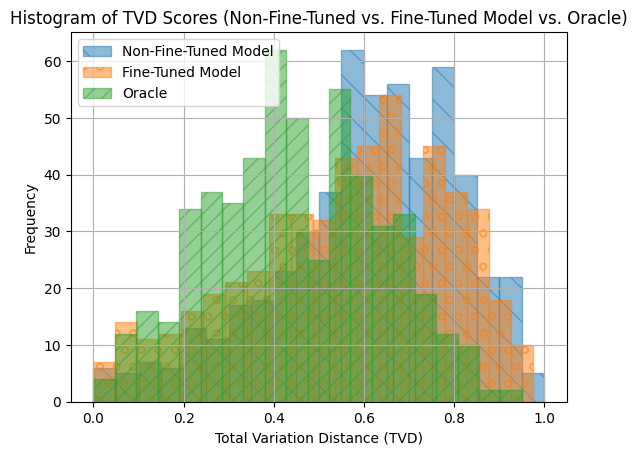

In [ ]:
plot_tvd_scores_comparison(tvd_scores_non_fine_tuned[123], tvd_scores_fine_tuned_ht[123], tvd_scores_oracle[123])

Mean TVD: 0.6071584462963575


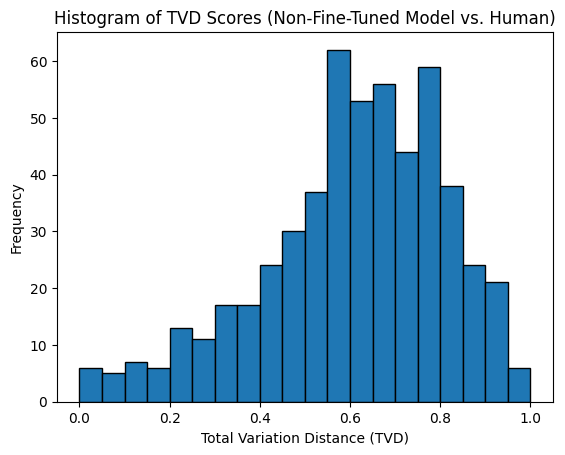

Mean TVD: 0.5541572812785548


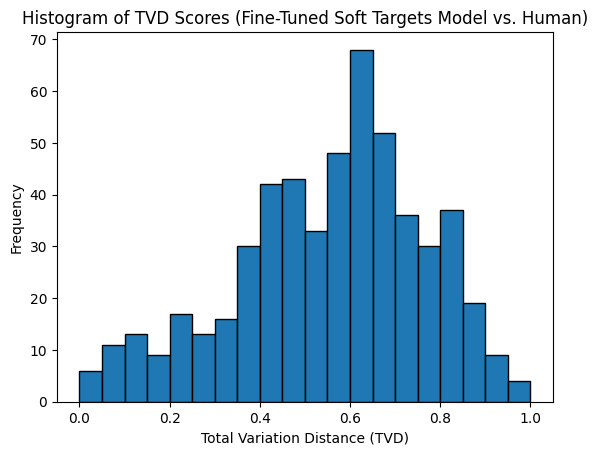

Mean TVD: 0.5603529863533598


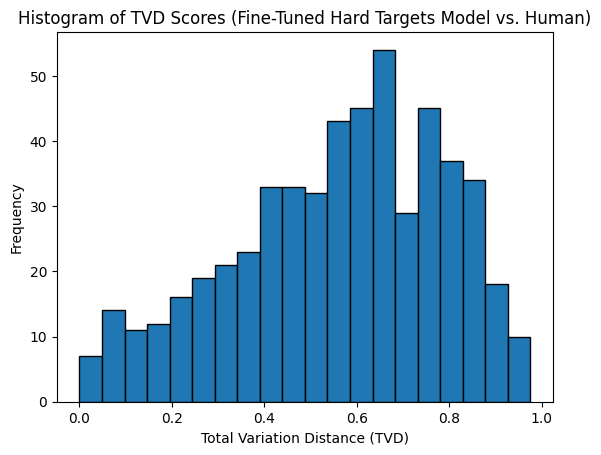

Mean TVD: 0.4448719747129016


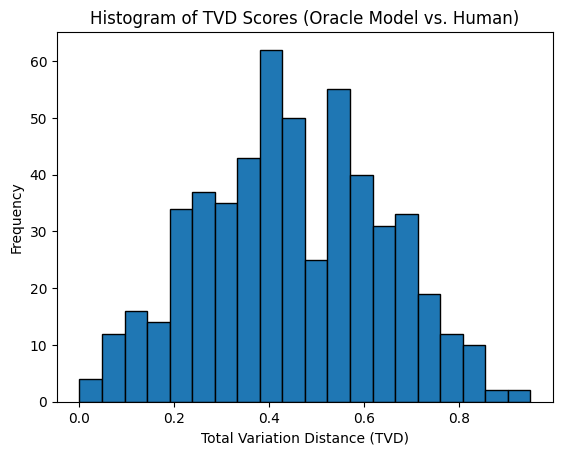

In [ ]:
# plot them seperately
plot_tvd_scores(tvd_scores_non_fine_tuned[123], model='Non-Fine-Tuned')
plot_tvd_scores(tvd_scores_fine_tuned[123], model='Fine-Tuned Soft Targets')
plot_tvd_scores(tvd_scores_fine_tuned_ht[123], model='Fine-Tuned Hard Targets')
plot_tvd_scores(tvd_scores_oracle[123], model='Oracle')


In [ ]:
# Save tvd scores to CSV
import pandas as pd
tvd_scores_df = pd.DataFrame({
    'Seed': seeds,
    'Mean TVD Non-Fine-Tuned': mean_tvd_non_fine_tuned,
    'Mean TVD Fine-Tuned': mean_tvd_fine_tuned,
    'Mean TVD Fine-Tuned HT': mean_tvd_fine_tuned_ht,
    'Oracle TVD': mean_tvd_oracle,
    'Full TVD Non-Fine-Tuned': [tvd_scores_non_fine_tuned[seed] for seed in seeds],
    'Full TVD Fine-Tuned': [tvd_scores_fine_tuned[seed] for seed in seeds],
    'Full TVD Fine-Tuned HT': [tvd_scores_fine_tuned_ht[seed] for seed in seeds],
    'Full TVD Oracle': [tvd_scores_oracle[seed] for seed in seeds]
})
tvd_scores_df.to_csv('tvd_scores.csv', index=False)
print(tvd_scores_df)
print("TVD scores saved to tvd_scores.csv")

   Seed  Mean TVD Non-Fine-Tuned  Mean TVD Fine-Tuned  Mean TVD Fine-Tuned HT  \
0    42                 0.607765             0.546901                0.558189   
1   123                 0.607158             0.554157                0.560353   
2   456                 0.606367             0.549389                0.549218   

   Oracle TVD                            Full TVD Non-Fine-Tuned  \
0    0.443361  [0.7067073170731708, 0.7792682926829267, 0.728...   
1    0.444872  [0.7512195121951222, 0.8768292682926828, 0.853...   
2    0.438766  [0.7054878048780489, 0.8518292682926828, 0.777...   

                                 Full TVD Fine-Tuned  \
0  [0.6798780487804879, 0.9024390243902438, 0.975...   
1  [0.7048780487804879, 0.8530487804878049, 0.901...   
2  [0.651829268292683, 0.9024390243902438, 0.8774...   

                              Full TVD Fine-Tuned HT  \
0  [0.7304878048780489, 0.8774390243902439, 0.925...   
1  [0.7554878048780488, 0.8530487804878049, 0.851...   
2  [0.730

### Analysis 1a

In [ ]:
def analyze_context_improvements(test_data, tvd_scores_non_fine_tuned, tvd_scores_fine_tuned, seed=42):
    """
    Analyze which contexts benefited from fine-tuning and group them by improvement magnitude.

    Args:
        test_data: Dictionary of test contexts
        tvd_scores_non_fine_tuned: Dictionary of TVD scores for non-fine-tuned model
        tvd_scores_fine_tuned: Dictionary of TVD scores for fine-tuned model
        seed: Seed to use for model comparison

    Returns:
        Dictionary with categorized contexts and their improvement metrics
    """
    # Get TVD scores for the specified seed
    non_ft_scores = tvd_scores_non_fine_tuned[seed]
    ft_scores = tvd_scores_fine_tuned[seed]

    # Calculate improvement for each context
    improvements = []
    test_keys = list(test_data.keys())

    for i, (key, context_data) in enumerate(test_data.items()):
        if i >= len(non_ft_scores) or i >= len(ft_scores):
            print(f"Warning: Index {i} out of range for TVD scores")
            continue

        non_ft_tvd = non_ft_scores[i]
        ft_tvd = ft_scores[i]
        improvement = non_ft_tvd - ft_tvd

        context_text = ' '.join(context_data['context'])

        improvements.append({
            'index': i,
            'key': key,
            'context': context_text,
            'non_ft_tvd': non_ft_tvd,
            'ft_tvd': ft_tvd,
            'improvement': improvement,
            'improvement_percent': (improvement / non_ft_tvd) * 100 if non_ft_tvd > 0 else 0,
            'context_data': context_data
        })

    # Sort by improvement (largest first)
    improvements.sort(key=lambda x: x['improvement'], reverse=True)

    # Create categories
    improved = [item for item in improvements if item['improvement'] > 0]
    worsened = [item for item in improvements if item['improvement'] <= 0]

    # Group by magnitude
    large_improvement = [item for item in improved if item['improvement'] > 0.2]
    medium_improvement = [item for item in improved if 0.1 < item['improvement'] <= 0.2]
    small_improvement = [item for item in improved if 0 < item['improvement'] <= 0.1]

    large_regression = [item for item in worsened if item['improvement'] < -0.2]
    medium_regression = [item for item in worsened if -0.2 <= item['improvement'] < -0.1]
    small_regression = [item for item in worsened if -0.1 <= item['improvement'] <= 0]

    # Calculate statistics
    avg_improvement = sum(item['improvement'] for item in improved) / len(improved) if improved else 0
    avg_regression = sum(item['improvement'] for item in worsened) / len(worsened) if worsened else 0

    results = {
        'improved': improved,
        'worsened': worsened,
        'large_improvement': large_improvement,
        'medium_improvement': medium_improvement,
        'small_improvement': small_improvement,
        'large_regression': large_regression,
        'medium_regression': medium_regression,
        'small_regression': small_regression,
        'stats': {
            'total_contexts': len(improvements),
            'improved_contexts': len(improved),
            'worsened_contexts': len(worsened),
            'improvement_ratio': len(improved) / len(improvements) if improvements else 0,
            'avg_improvement': avg_improvement,
            'avg_regression': avg_regression
        }
    }

    return results

def print_context_analysis(analysis_results, model_non_ft, model_ft, tokenizer, device, num_examples=3):
    """
    Print a summary of the context analysis with examples, including model outputs.

    Args:
        analysis_results: Output from analyze_context_improvements
        model_non_ft: Non-fine-tuned model for generating samples
        model_ft: Fine-tuned model for generating samples
        tokenizer: Tokenizer for both models
        device: Device to run models on
        num_examples: Number of examples to show for each category
    """
    stats = analysis_results['stats']

    print(f"=== Context Analysis Summary ===")
    print(f"Total contexts analyzed: {stats['total_contexts']}")
    print(f"Contexts with improved TVD: {stats['improved_contexts']} ({stats['improvement_ratio']:.1%})")
    print(f"Contexts with worsened TVD: {stats['worsened_contexts']} ({1-stats['improvement_ratio']:.1%})")
    print(f"Average improvement where better: {stats['avg_improvement']:.4f}")
    print(f"Average regression where worse: {stats['avg_regression']:.4f}")

    print("\n=== Improvement Categories ===")
    print(f"Large improvements (>0.2): {len(analysis_results['large_improvement'])}")
    print(f"Medium improvements (0.1-0.2): {len(analysis_results['medium_improvement'])}")
    print(f"Small improvements (0-0.1): {len(analysis_results['small_improvement'])}")
    print(f"Small regressions (0 to -0.1): {len(analysis_results['small_regression'])}")
    print(f"Medium regressions (-0.1 to -0.2): {len(analysis_results['medium_regression'])}")
    print(f"Large regressions (< -0.2): {len(analysis_results['large_regression'])}")

    # Categories to analyze
    categories = [
        ('Large Improvements', 'large_improvement'),
        ('Medium Improvements', 'medium_improvement'),
        ('Small Improvements', 'small_improvement'),
        ('Small Regressions', 'small_regression'),
        ('Medium Regressions', 'medium_regression'),
        ('Large Regressions', 'large_regression')
    ]

    for title, category in categories:
        items = analysis_results[category][:num_examples]
        if items:
            print(f"\n=== {title} (showing {min(num_examples, len(items))} examples) ===")
            for i, item in enumerate(items):
                context = item['context']
                print(f"{i+1}. Context: \"{context}\"")
                print(f"   Non-fine-tuned TVD: {item['non_ft_tvd']:.4f}, Fine-tuned TVD: {item['ft_tvd']:.4f}")
                print(f"   Improvement: {item['improvement']:.4f} ({item['improvement_percent']:.1f}%)")

                # Show human predictions
                if 'human_next_word_pred' in item['context_data']:
                    top_human_preds = sorted(item['context_data']['human_next_word_pred'],
                                            key=lambda x: x[1],
                                            reverse=True)[:5]
                    human_words = [f"{word} ({count})" for word, count in top_human_preds]
                    print(f"   Top human predictions: {', '.join(human_words)}")

                # Generate model samples for both models
                print("   Model predictions:")
                with torch.no_grad():
                    # Non-fine-tuned model predictions
                    model_non_ft.eval()
                    non_ft_samples = get_model_samples(model_non_ft, tokenizer, context, n_samples=40)
                    non_ft_samples = [x for x in non_ft_samples if x != 'Failed to generate word']

                    # Get distribution from samples
                    non_ft_counter = Counter(non_ft_samples)
                    non_ft_dist = [(word, count) for word, count in non_ft_counter.most_common(5)]
                    non_ft_words = [f"{word} ({count})" for word, count in non_ft_dist]

                    # Fine-tuned model predictions
                    model_ft.eval()
                    ft_samples = get_model_samples(model_ft, tokenizer, context, n_samples=40)
                    ft_samples = [x for x in ft_samples if x != 'Failed to generate word']

                    # Get distribution from samples
                    ft_counter = Counter(ft_samples)
                    ft_dist = [(word, count) for word, count in ft_counter.most_common(5)]
                    ft_words = [f"{word} ({count})" for word, count in ft_dist]

                print(f"   - Non-fine-tuned: {', '.join(non_ft_words)}")
                print(f"   - Fine-tuned: {', '.join(ft_words)}")
                print("-" * 80)


In [ ]:
# First, load both models
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token

# Load non-fine-tuned model (from saved path)
model_non_ft = GPT2LMHeadModel.from_pretrained("./gpt2_seed_123")
model_non_ft.to(device)

# Load fine-tuned model (from saved path)
model_ft = GPT2LMHeadModel.from_pretrained("./fine_tuned_gpt2_seed_123")
model_ft.to(device)

# Run the analysis
analysis = analyze_context_improvements(test_data, tvd_scores_non_fine_tuned, tvd_scores_fine_tuned, seed=42)

# Print results with model outputs
print_context_analysis(analysis, model_non_ft, model_ft, tokenizer, device, num_examples=2)

# Dominant Word Adoption Analysis
How much of TVD increase is due to predicting the most dominant word often versus predicting the different words better

In [ ]:
from tqdm import tqdm
def classify_contexts_by_consensus(test_data, high_threshold=0.7, low_threshold=0.4):
    high_consensus = []
    mid_consensus = []
    low_consensus = []

    consensus_stats = {}

    for key, context_data in test_data.items():
        # Get human next word predictions
        human_preds = context_data['human_next_word_pred']

        if not human_preds:
            continue

        total_responses = sum(count for _, count in human_preds)

        if total_responses == 0:
            continue

        # Find dominant word and its percentage
        dominant_word, dominant_count = max(human_preds, key=lambda x: x[1])
        dominant_percentage = dominant_count / total_responses

        context_info = {
            'key': key,
            'context': ' '.join(context_data['context']),
            'dominant_word': dominant_word,
            'dominant_percentage': dominant_percentage,
            'total_responses': total_responses,
            'num_unique_responses': len(human_preds),
            'context_data': context_data
        }

        if dominant_percentage >= high_threshold:
            high_consensus.append(context_info)
        elif dominant_percentage >= low_threshold:
            mid_consensus.append(context_info)
        else:
            low_consensus.append(context_info)

        consensus_stats[key] = {
            'dominant_percentage': dominant_percentage,
            'category': 'high' if dominant_percentage >= high_threshold else
                       'mid' if dominant_percentage >= low_threshold else 'low'
        }

    return {
        'high_consensus': high_consensus,
        'mid_consensus': mid_consensus,
        'low_consensus': low_consensus,
        'consensus_stats': consensus_stats
    }

def analyze_tvd_by_consensus_level(test_data, tvd_scores_non_ft, tvd_scores_ft,
                                  consensus_classification, seed=123):
    non_ft_scores = tvd_scores_non_ft[seed]
    ft_scores = tvd_scores_ft[seed]
    consensus_stats = consensus_classification['consensus_stats']

    # Initialize results containers
    results = {
        'high': {'tvd_improvements': [], 'contexts': []},
        'mid': {'tvd_improvements': [], 'contexts': []},
        'low': {'tvd_improvements': [], 'contexts': []}
    }

    # For each context, calculate TVD improvement and categorize
    for i, (key, context_data) in enumerate(test_data.items()):
        if i >= len(non_ft_scores) or i >= len(ft_scores) or key not in consensus_stats:
            continue

        non_ft_tvd = non_ft_scores[i]
        ft_tvd = ft_scores[i]
        improvement = non_ft_tvd - ft_tvd

        category = consensus_stats[key]['category']

        context_info = {
            'key': key,
            'context': ' '.join(context_data['context']),
            'non_ft_tvd': non_ft_tvd,
            'ft_tvd': ft_tvd,
            'improvement': improvement,
            'improvement_percent': (improvement / non_ft_tvd) * 100 if non_ft_tvd > 0 else 0,
            'dominant_percentage': consensus_stats[key]['dominant_percentage']
        }

        results[category]['tvd_improvements'].append(improvement)
        results[category]['contexts'].append(context_info)

    # Calculate statistics for each category
    for category in results:
        improvements = results[category]['tvd_improvements']
        results[category]['avg_improvement'] = np.mean(improvements) if improvements else 0
        results[category]['median_improvement'] = np.median(improvements) if improvements else 0
        results[category]['std_improvement'] = np.std(improvements) if improvements else 0
        results[category]['count'] = len(improvements)

        # Count positive and negative improvements
        positive_improvements = [i for i in improvements if i > 0]
        results[category]['positive_count'] = len(positive_improvements)
        results[category]['positive_ratio'] = len(positive_improvements) / len(improvements) if improvements else 0
        results[category]['avg_positive'] = np.mean(positive_improvements) if positive_improvements else 0

    return results

def analyze_dominant_word_adoption(test_data, model_non_ft, model_ft, seed=123):
    # # Load both models
    # tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    # tokenizer.pad_token = tokenizer.eos_token

    # model_non_ft = GPT2LMHeadModel.from_pretrained(f"./models/gpt2_seed_{seed}")
    # model_non_ft.to(device)
    # model_non_ft.eval()

    # model_ft = GPT2LMHeadModel.from_pretrained(f"./models/fine_tuned_gpt2_seed_{seed}")
    # model_ft.to(device)
    # model_ft.eval()

    # Initialize results
    results = {
        'high': {'non_ft_accuracy': [], 'ft_accuracy': [], 'human_dominant_percentage': [], 'contexts': []},
        'mid': {'non_ft_accuracy': [], 'ft_accuracy': [], 'human_dominant_percentage': [], 'contexts': []},
        'low': {'non_ft_accuracy': [], 'ft_accuracy': [], 'human_dominant_percentage': [], 'contexts': []}
    }

    # Analyze each context
    consensus_data = classify_contexts_by_consensus(test_data)
    consensus_stats = consensus_data['consensus_stats']

    for key, context_data in tqdm(test_data.items()):
        # print(f"Analyzing context: {key}") # Optional: for debugging
        if key not in consensus_stats:
            continue

        # Get context and dominant human response
        context = ' '.join(context_data['context'])
        human_preds = context_data['human_next_word_pred']
        if not human_preds: # Ensure human_preds is not empty
            continue
        dominant_word, _ = max(human_preds, key=lambda x: x[1])

        # Get samples from both models
        with torch.no_grad():
            non_ft_samples = get_model_samples(model_non_ft, tokenizer, context, n_samples=40)
            non_ft_samples = [x for x in non_ft_samples if x != 'Failed to generate word']

            ft_samples = get_model_samples(model_ft, tokenizer, context, n_samples=40)
            ft_samples = [x for x in ft_samples if x != 'Failed to generate word']

        # Calculate dominant word accuracy
        non_ft_accuracy = non_ft_samples.count(dominant_word.lower()) / len(non_ft_samples) if non_ft_samples else 0
        ft_accuracy = ft_samples.count(dominant_word.lower()) / len(ft_samples) if ft_samples else 0

        category = consensus_stats[key]['category']
        human_dom_percent = consensus_stats[key]['dominant_percentage']

        context_info = {
            'key': key,
            'context': context,
            'dominant_word': dominant_word,
            'dominant_percentage': human_dom_percent,
            'non_ft_accuracy': non_ft_accuracy,
            'ft_accuracy': ft_accuracy,
            'improvement': ft_accuracy - non_ft_accuracy
        }

        results[category]['non_ft_accuracy'].append(non_ft_accuracy)
        results[category]['ft_accuracy'].append(ft_accuracy)
        results[category]['human_dominant_percentage'].append(human_dom_percent)
        results[category]['contexts'].append(context_info)

    # Calculate statistics for each category
    for category in results:
        results[category]['avg_non_ft_accuracy'] = np.mean(results[category]['non_ft_accuracy']) if results[category]['non_ft_accuracy'] else 0
        results[category]['avg_ft_accuracy'] = np.mean(results[category]['ft_accuracy']) if results[category]['ft_accuracy'] else 0
        results[category]['avg_human_dominant_percentage'] = np.mean(results[category]['human_dominant_percentage']) if results[category]['human_dominant_percentage'] else 0
        results[category]['avg_improvement'] = results[category]['avg_ft_accuracy'] - results[category]['avg_non_ft_accuracy']
        results[category]['count'] = len(results[category]['contexts'])

    return results

def plot_consensus_analysis(tvd_results, dominant_word_results):
    """
    Plot the results of the consensus analysis.

    Args:
        tvd_results: Result from analyze_tvd_by_consensus_level
        dominant_word_results: Result from analyze_dominant_word_adoption
    """
    # Set up the figure with multiple subplots
    fig, axs = plt.subplots(3, 1, figsize=(15, 24))

    # 1. TVD Improvement by consensus level
    categories = ['high', 'mid', 'low']
    avg_improvements = [tvd_results[cat]['avg_improvement'] for cat in categories]

    axs[0].bar(categories, avg_improvements)
    axs[0].set_title('Average TVD Improvement by Consensus Level')
    axs[0].set_ylabel('TVD Improvement (Non-FT - FT)')

    # 2. Dominant word accuracy by consensus level
    non_ft_accuracies = [dominant_word_results[cat]['avg_non_ft_accuracy'] for cat in categories]
    ft_accuracies = [dominant_word_results[cat]['avg_ft_accuracy'] for cat in categories]
    human_dominant_percentages = [dominant_word_results[cat]['avg_human_dominant_percentage'] for cat in categories]

    x = np.arange(len(categories))
    width = 0.25 # Adjusted width for three bars

    axs[1].bar(x - width, non_ft_accuracies, width, label='Non-Fine-Tuned')
    axs[1].bar(x, ft_accuracies, width, label='Fine-Tuned')
    axs[1].bar(x + width, human_dominant_percentages, width, label='Human', color='green', alpha=0.7)

    axs[1].set_xticks(x)
    axs[1].set_xticklabels(categories)
    axs[1].set_title('Dominant Word Prediction')
    axs[1].set_ylabel('Dominant Percentage')
    axs[1].legend()

    # Additional plot: Positive improvement ratio by category
    positive_ratios = [tvd_results[cat]['positive_ratio'] for cat in categories]

    axs[2].bar(categories, positive_ratios)
    axs[2].set_title('Proportion of Contexts with Positive TVD Improvement')
    axs[2].set_ylabel('Proportion')

    for i, cat in enumerate(categories):
        count = f"{tvd_results[cat]['positive_count']}/{tvd_results[cat]['count']}"
        axs[2].text(i, positive_ratios[i] + 0.02, count, ha='center')

    plt.show()

In [ ]:
def get_tvd_diff_and_dominant_percentage_data(test_data, tvd_scores_non_ft, tvd_scores_ft, consensus_classification, seed=123):

    if seed not in tvd_scores_non_ft or seed not in tvd_scores_ft:
        print(f"Error: TVD scores for seed {seed} not found in one or both TVD score dictionaries.")
        return []

    non_ft_scores_for_seed = tvd_scores_non_ft[seed]
    ft_scores_for_seed = tvd_scores_ft[seed]

    if not test_data:
        print("Error: test_data is empty.")
        return []

    if len(non_ft_scores_for_seed) != len(test_data) or len(ft_scores_for_seed) != len(test_data):
        print(f"Error: Length mismatch. Non-FT scores: {len(non_ft_scores_for_seed)}, FT scores: {len(ft_scores_for_seed)}, Test data: {len(test_data)}.")
        print("Ensure TVD scores correspond to all items in test_data for the given seed.")
        return []

    plot_data_points = []
    test_data_items = list(test_data.items())

    for i, (key, context_data) in enumerate(test_data_items):
        if key not in consensus_classification['consensus_stats']:
            continue

        non_ft_tvd = non_ft_scores_for_seed[i]
        ft_tvd = ft_scores_for_seed[i]

        if pd.isna(non_ft_tvd) or pd.isna(ft_tvd):
            continue

        tvd_difference = non_ft_tvd - ft_tvd # This will be X
        dominant_percentage = consensus_classification['consensus_stats'][key]['dominant_percentage']

        plot_data_points.append((tvd_difference, dominant_percentage))

    if not plot_data_points:
        print("No valid data points were generated for plotting.")

    return plot_data_points

def plot_tvd_diff_vs_dominant_percentage(prepared_data, seed_value, model_name):
    if not prepared_data:
        print("No data to plot.")
        return

    tvd_differences = np.array([item[0] for item in prepared_data]) # X-axis
    dominant_percentages = np.array([item[1] for item in prepared_data]) # Y-axis

    plt.figure(figsize=(10, 6))
    plt.scatter(tvd_differences, dominant_percentages, alpha=0.6, edgecolors='w', linewidth=0.5, label='Contexts')

    # Add regression line
    if len(tvd_differences) > 1: # Need at least 2 points for a line
        # Fit line: y = m*x + b, where x is tvd_differences, y is dominant_percentages
        m, b = np.polyfit(tvd_differences, dominant_percentages, 1)
        plt.plot(tvd_differences, m * tvd_differences + b, color='green', linestyle='-', linewidth=1.5, label=f'Regression Line (y={m:.2f}x+{b:.2f})')

    plt.axvline(0, color='red', linestyle='--', linewidth=0.8, label='No TVD Change (Improvement > 0 to the right)')

    plt.title(f'Human Dominant Word % vs. TVD Improvement (Model {model_name})')
    plt.xlabel('TVD Improvement (Non-FT TVD - FT TVD)')
    plt.ylabel('Human Dominant Word Percentage')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()

consensus_classification_output = classify_contexts_by_consensus(test_data)
print("Finished classifying contexts by consensus level.")

seed_for_analysis = 123

data_for_plot = get_tvd_diff_and_dominant_percentage_data(
    test_data,
    tvd_scores_non_fine_tuned,
    tvd_scores_fine_tuned,
    consensus_classification_output,
    seed=seed_for_analysis
)

if data_for_plot:
    plot_tvd_diff_vs_dominant_percentage(data_for_plot, seed_value=seed_for_analysis, model_name='Fine-Tuned Soft Targets')
else:
    print(f"Could not generate data for plotting for seed {seed_for_analysis}.")

data_for_plot = get_tvd_diff_and_dominant_percentage_data(
    test_data,
    tvd_scores_non_fine_tuned,
    tvd_scores_fine_tuned_ht,
    consensus_classification_output,
    seed=seed_for_analysis
)

plot_tvd_diff_vs_dominant_percentage(data_for_plot, seed_value=seed_for_analysis, model_name='Fine-Tuned Hard Targets')

In [ ]:
# Classify contexts by consensus level
consensus_classification = classify_contexts_by_consensus(test_data)
print("Finished classifying contexts by consensus level.")

# Analyze TVD scores by consensus level
tvd_analysis = analyze_tvd_by_consensus_level(
    test_data,
    tvd_scores_non_fine_tuned,
    tvd_scores_fine_tuned,
    consensus_classification
)
print("Finished analyzing TVD scores by consensus level.")

# Analyze dominant word adoption
dominant_word_analysis = analyze_dominant_word_adoption(test_data, model_non_ft, model_ft)
print("Finished analyzing dominant word adoption.")

for category in ['high', 'mid', 'low']:
    print(f"\n=== {category.capitalize()} Consensus Contexts ===")
    print(f"Count: {tvd_analysis[category]['count']}")
    print(f"Avg TVD improvement: {tvd_analysis[category]['avg_improvement']:.4f}")
    print(f"% contexts improved: {tvd_analysis[category]['positive_ratio']:.1%}")
    print(f"Human Dominant Word Avg. Percentage: {dominant_word_analysis[category]['avg_human_dominant_percentage']:.2%}")
    print(f"Dominant word prediction - Non-FT: {dominant_word_analysis[category]['avg_non_ft_accuracy']:.2%}")
    print(f"Dominant word prediction - FT: {dominant_word_analysis[category]['avg_ft_accuracy']:.2%}")

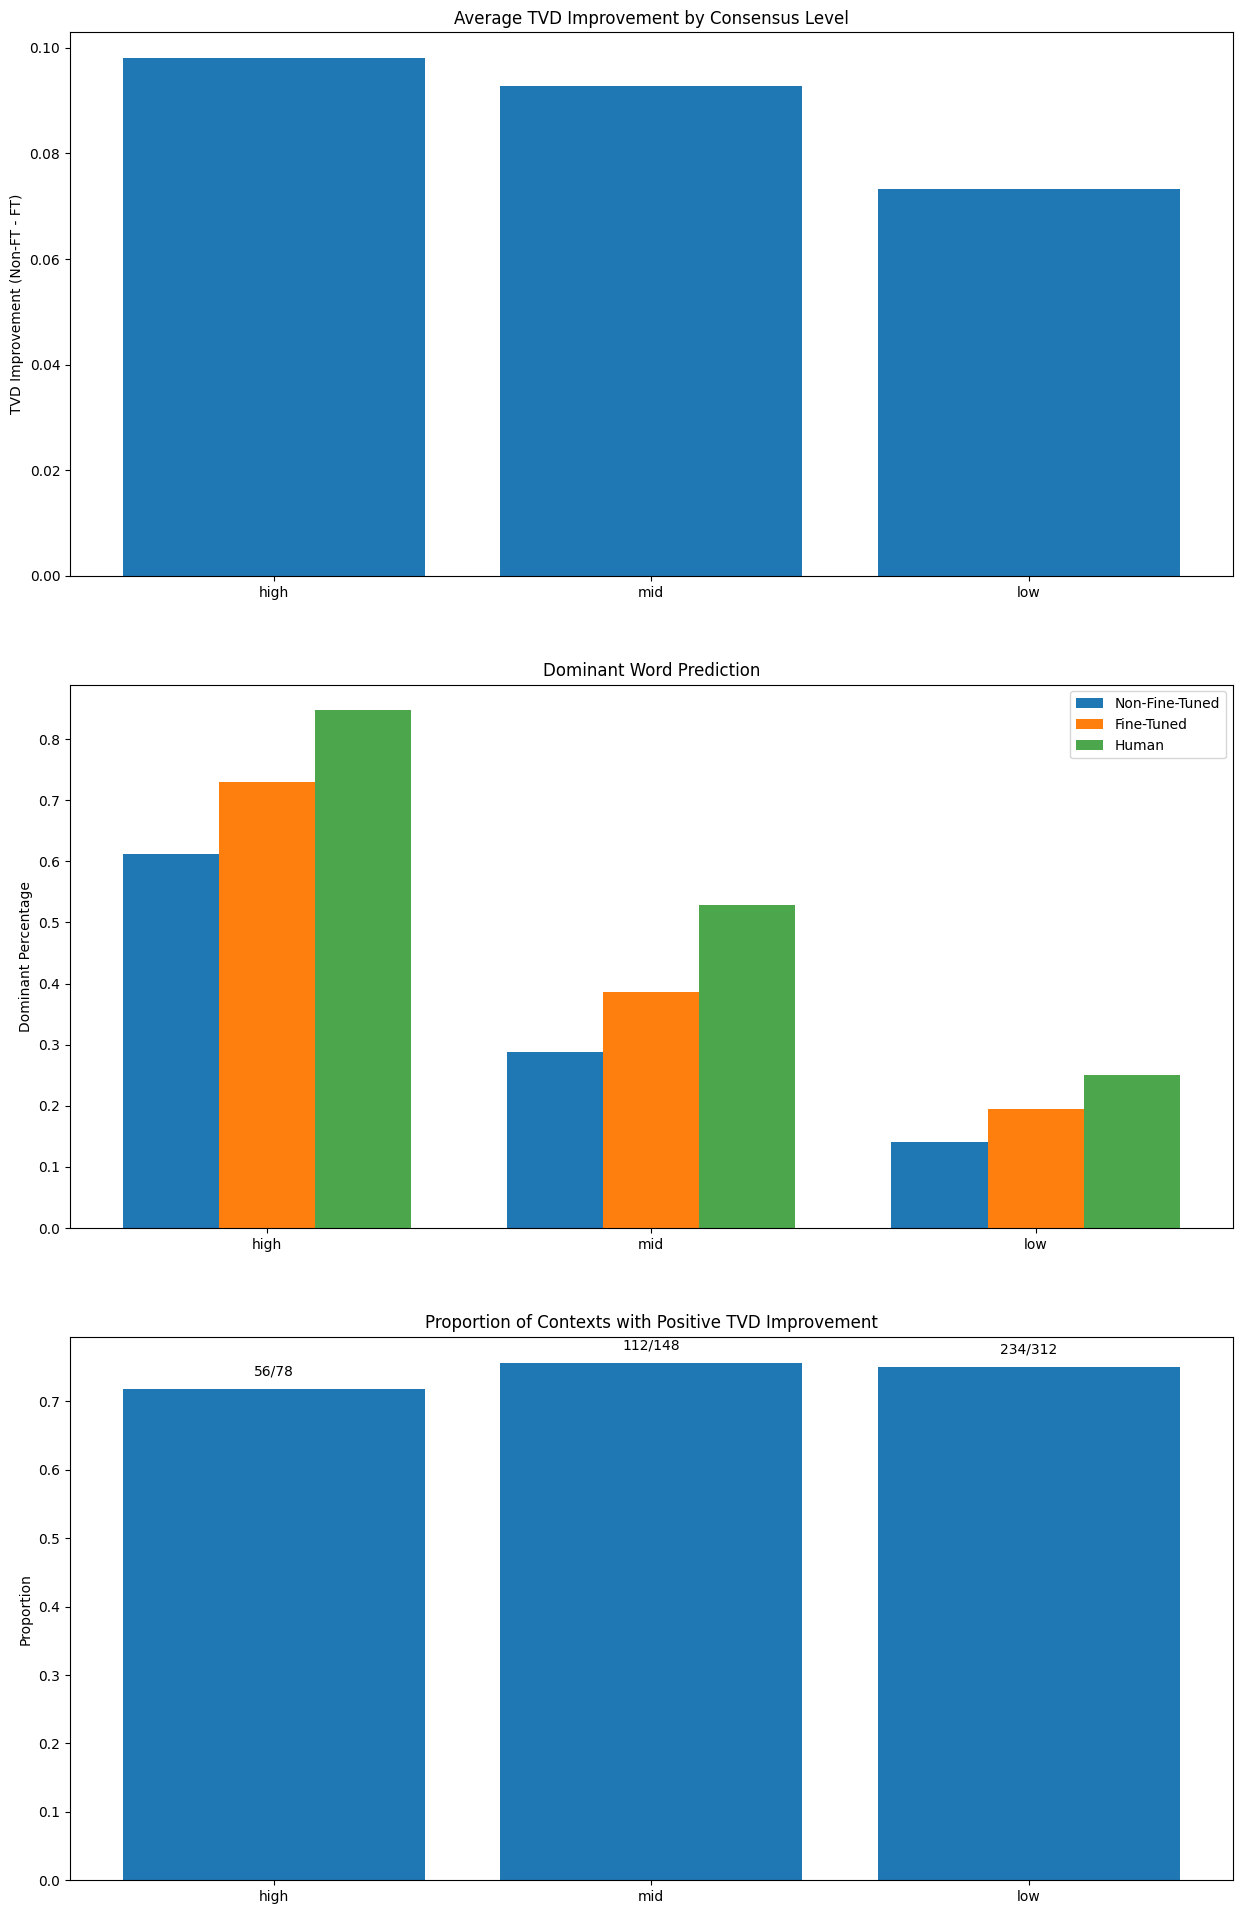

In [ ]:
# Plot the results
plot_consensus_analysis(tvd_analysis, dominant_word_analysis)

# Unique Word Coverage


Unique word comparison including HT model

100%|██████████| 536/536 [04:16<00:00,  2.09it/s]


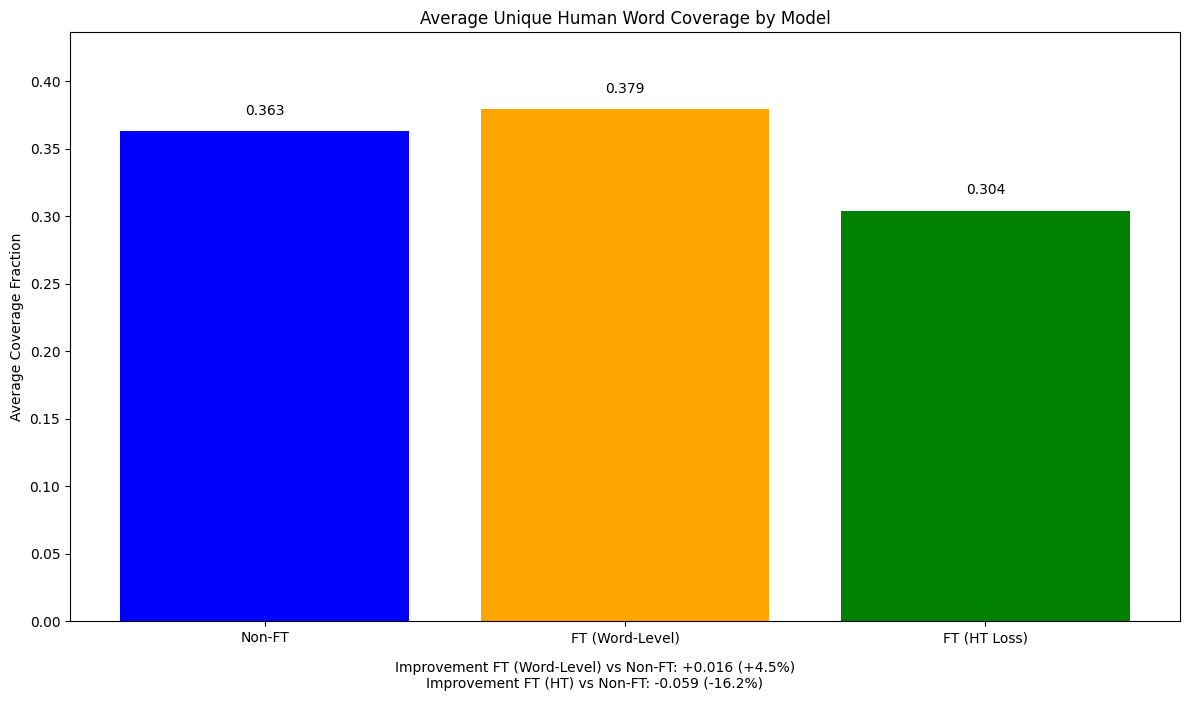

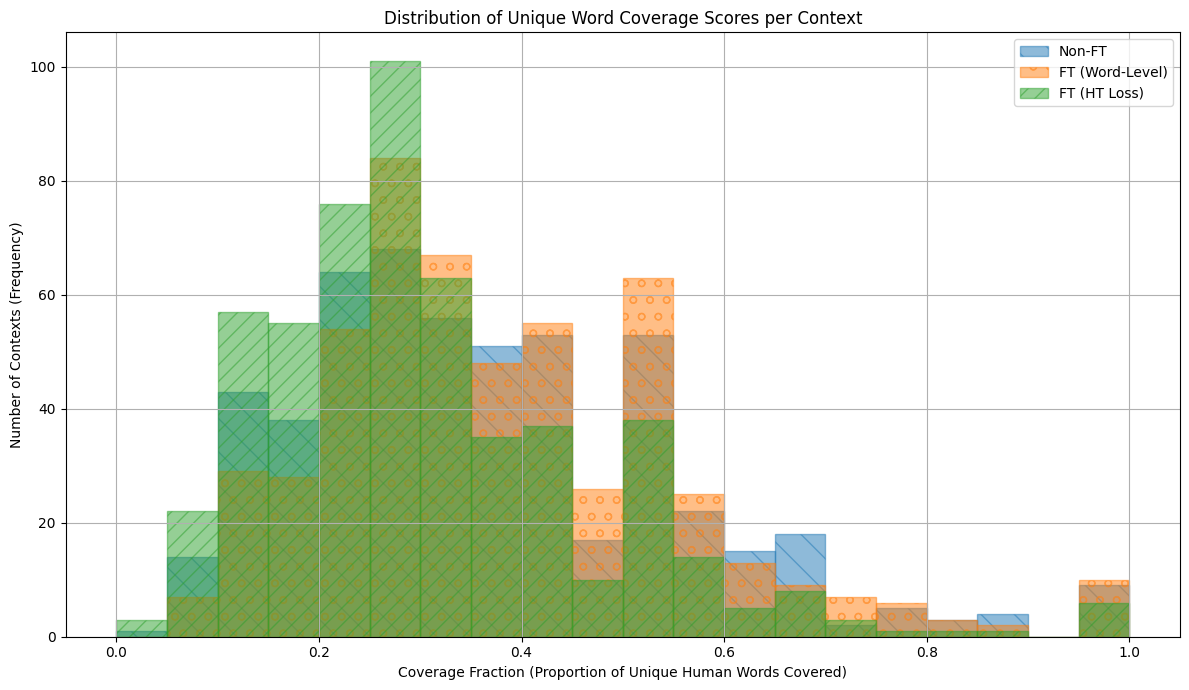

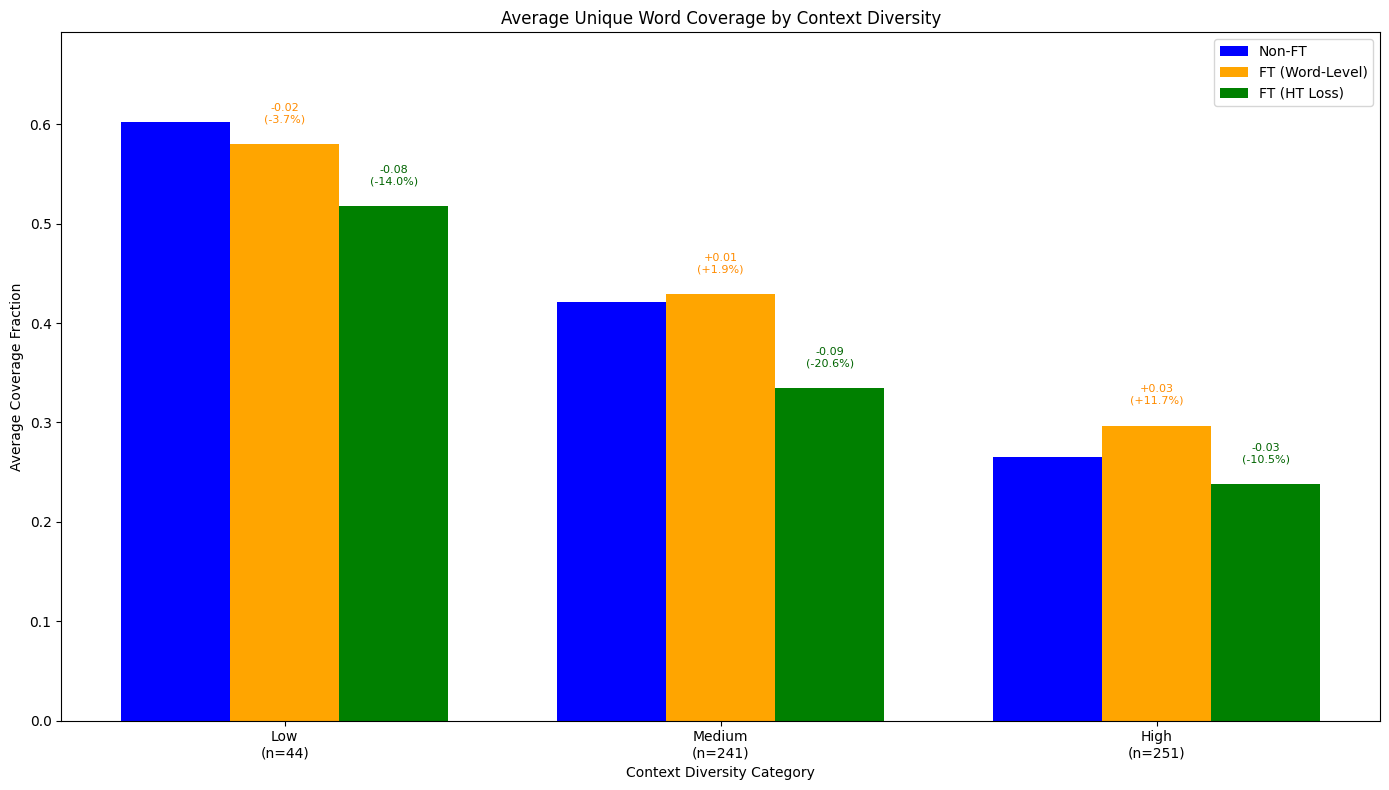

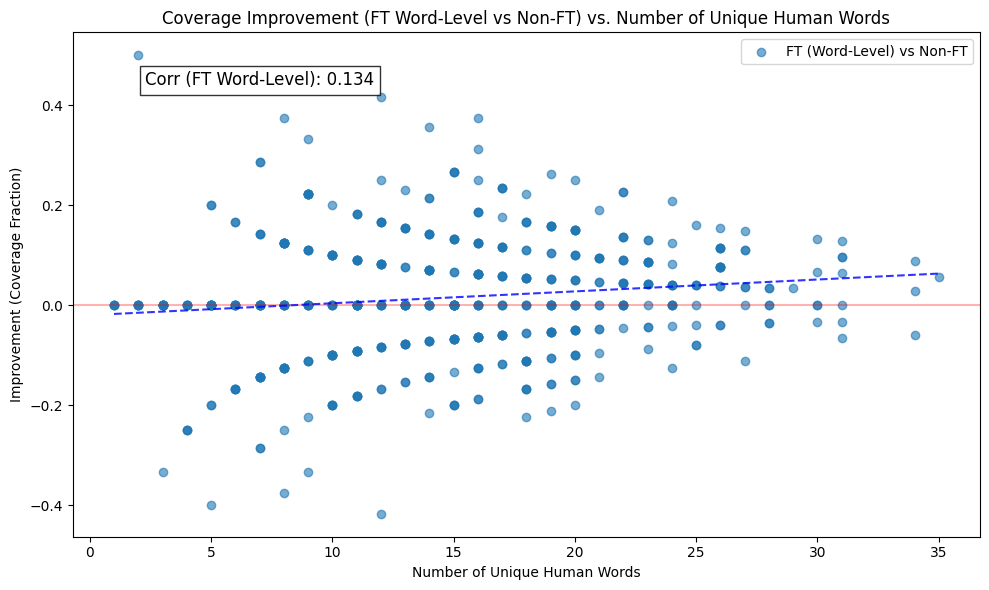

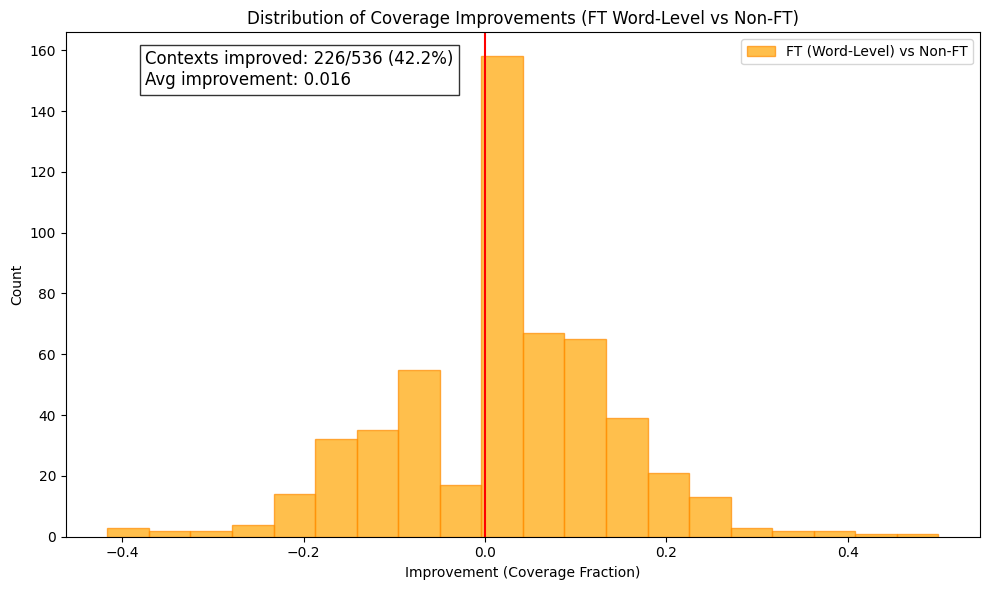


=== Unique Word Coverage Analysis ===
Average coverage (Non-Fine-Tuned): 0.363
Average coverage (Fine-Tuned Word-Level): 0.379


KeyError: 'avg_ft_ft_coverage'

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_unique_word_coverage_ht(test_data, non_ft_model, ft_model, model_ft_ht, seed=123):

    results = {
        'non_ft_coverage': [],  # Fraction of unique human words covered by non-fine-tuned model
        'ft_coverage': [],      # Fraction of unique human words covered by fine-tuned model (word-level)
        'ft_ht_coverage': [],   # Fraction of unique human words covered by fine-tuned model (HT)
        'num_unique_human': [], # Number of unique human responses per context
        'contexts': []          # Context information
    }

    # Classify contexts by number of unique responses
    low_diversity = []  # Contexts with few unique responses (1-5)
    med_diversity = []  # Contexts with moderate unique responses (6-15)
    high_diversity = [] # Contexts with many unique responses (>15)

    # Process each context
    for idx, (key, sample_data) in enumerate(tqdm(list(test_data.items()))):
        # Get context and human next word predictions
        context_list = sample_data['context']
        context = ' '.join(context_list)
        human_preds = sample_data['human_next_word_pred']

        if not human_preds:
            continue

        unique_human_words = [word for word, _ in human_preds] # Ensure human words are also lowercased for comparison
        num_unique_human = len(unique_human_words)

        # Generate samples from all models
        with torch.no_grad():
            # Get samples from non-fine-tuned model
            non_ft_samples = get_model_samples(non_ft_model, tokenizer, context, n_samples=40)
            non_ft_samples = [x.lower() for x in non_ft_samples if x != 'Failed to generate word']
            unique_non_ft = list(set(non_ft_samples))

            # Get samples from fine-tuned model (word-level)
            ft_samples = get_model_samples(ft_model, tokenizer, context, n_samples=40)
            ft_samples = [x.lower() for x in ft_samples if x != 'Failed to generate word']
            unique_ft = list(set(ft_samples))

            # Get samples from fine-tuned model (HT)
            ft_ht_samples = get_model_samples(model_ft_ht, tokenizer, context, n_samples=40)
            ft_ht_samples = [x.lower() for x in ft_ht_samples if x != 'Failed to generate word']
            unique_ft_ht = list(set(ft_ht_samples))

        # Calculate coverage
        non_ft_covered_count = sum(1 for word in unique_human_words if word in unique_non_ft)
        ft_covered_count = sum(1 for word in unique_human_words if word in unique_ft)
        ft_ht_covered_count = sum(1 for word in unique_human_words if word in unique_ft_ht)

        non_ft_coverage_score = non_ft_covered_count / num_unique_human if num_unique_human > 0 else 0
        ft_coverage_score = ft_covered_count / num_unique_human if num_unique_human > 0 else 0
        ft_ht_coverage_score = ft_ht_covered_count / num_unique_human if num_unique_human > 0 else 0

        # Store results
        results['non_ft_coverage'].append(non_ft_coverage_score)
        results['ft_coverage'].append(ft_coverage_score)
        results['ft_ht_coverage'].append(ft_ht_coverage_score)
        results['num_unique_human'].append(num_unique_human)

        # Store context information
        context_info = {
            'key': key,
            'context': context,
            'unique_human_words': unique_human_words,
            'unique_non_ft': unique_non_ft,
            'unique_ft': unique_ft,
            'unique_ft_ht': unique_ft_ht,
            'non_ft_coverage': non_ft_coverage_score,
            'ft_coverage': ft_coverage_score,
            'ft_ht_coverage': ft_ht_coverage_score,
            'improvement_ft_vs_non_ft': ft_coverage_score - non_ft_coverage_score,
            'improvement_ft_ht_vs_non_ft': ft_ht_coverage_score - non_ft_coverage_score,
            'num_unique_human': num_unique_human
        }
        results['contexts'].append(context_info)

        # Categorize by diversity
        if num_unique_human <= 5:
            low_diversity.append(context_info)
        elif num_unique_human <= 15:
            med_diversity.append(context_info)
        else:
            high_diversity.append(context_info)

    # Calculate average coverage by model
    results['avg_non_ft_coverage'] = np.mean(results['non_ft_coverage']) if results['non_ft_coverage'] else 0
    results['avg_ft_coverage'] = np.mean(results['ft_coverage']) if results['ft_coverage'] else 0
    results['avg_ft_ht_coverage'] = np.mean(results['ft_ht_coverage']) if results['ft_ht_coverage'] else 0

    results['avg_improvement_ft_vs_non_ft'] = results['avg_ft_coverage'] - results['avg_non_ft_coverage']
    results['avg_improvement_ft_ht_vs_non_ft'] = results['avg_ft_ht_coverage'] - results['avg_non_ft_coverage']


    # Calculate coverage by diversity category
    diversity_categories = {
        'low': low_diversity,
        'medium': med_diversity,
        'high': high_diversity
    }

    results['diversity_analysis'] = {}

    for category, contexts_in_cat in diversity_categories.items(): # Renamed 'contexts' to 'contexts_in_cat'
        if not contexts_in_cat:
            results['diversity_analysis'][category] = {
                'count': 0, 'avg_unique_human': 0,
                'avg_non_ft_coverage': 0, 'avg_ft_coverage': 0, 'avg_ft_ht_coverage': 0,
                'avg_improvement_ft_vs_non_ft': 0, 'avg_improvement_ft_ht_vs_non_ft': 0,
                'contexts': []
            }
            continue

        non_ft_coverage_cat = [ctx['non_ft_coverage'] for ctx in contexts_in_cat]
        ft_coverage_cat = [ctx['ft_coverage'] for ctx in contexts_in_cat]
        ft_ht_coverage_cat = [ctx['ft_ht_coverage'] for ctx in contexts_in_cat]

        avg_imp_ft_vs_non_ft_cat = np.mean([ctx['improvement_ft_vs_non_ft'] for ctx in contexts_in_cat]) if contexts_in_cat else 0
        avg_imp_ft_ht_vs_non_ft_cat = np.mean([ctx['improvement_ft_ht_vs_non_ft'] for ctx in contexts_in_cat]) if contexts_in_cat else 0

        avg_unique_human_cat = np.mean([ctx['num_unique_human'] for ctx in contexts_in_cat]) if contexts_in_cat else 0


        results['diversity_analysis'][category] = {
            'count': len(contexts_in_cat),
            'avg_unique_human': avg_unique_human_cat,
            'avg_non_ft_coverage': np.mean(non_ft_coverage_cat) if non_ft_coverage_cat else 0,
            'avg_ft_coverage': np.mean(ft_coverage_cat) if ft_coverage_cat else 0,
            'avg_ft_ht_coverage': np.mean(ft_ht_coverage_cat) if ft_ht_coverage_cat else 0,
            'avg_improvement_ft_vs_non_ft': avg_imp_ft_vs_non_ft_cat,
            'avg_improvement_ft_ht_vs_non_ft': avg_imp_ft_ht_vs_non_ft_cat,
            'contexts': contexts_in_cat
        }

    return results

def plot_word_coverage_results_ht(coverage_results):
    """
    Plot the results of the unique word coverage analysis.

    Args:
        coverage_results: Output from analyze_unique_word_coverage_ht
    """
    # 1. Overall coverage comparison (Bar Chart of Averages)
    labels_avg = ['Non-FT', 'FT (Word-Level)', 'FT (HT Loss)']
    avg_coverages = [
        coverage_results['avg_non_ft_coverage'],
        coverage_results['avg_ft_coverage'],
        coverage_results['avg_ft_ht_coverage']
    ]

    plt.figure(figsize=(12, 7))
    bars = plt.bar(labels_avg, avg_coverages, color=['blue', 'orange', 'green'])
    plt.title('Average Unique Human Word Coverage by Model')
    plt.ylabel('Average Coverage Fraction')
    plt.ylim(0, max(avg_coverages) * 1.15 if any(c > 0 for c in avg_coverages) else 1)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

    improvement_ft = coverage_results['avg_improvement_ft_vs_non_ft']
    improvement_ft_ht = coverage_results['avg_improvement_ft_ht_vs_non_ft']
    non_ft_cov_avg = coverage_results['avg_non_ft_coverage']
    percent_improvement_ft = (improvement_ft / non_ft_cov_avg * 100) if non_ft_cov_avg > 0 else 0
    percent_improvement_ft_ht = (improvement_ft_ht / non_ft_cov_avg * 100) if non_ft_cov_avg > 0 else 0
    figtext_str_avg = (f'Improvement FT (Word-Level) vs Non-FT: {improvement_ft:+.3f} ({percent_improvement_ft:+.1f}%)\n'
                       f'Improvement FT (HT) vs Non-FT: {improvement_ft_ht:+.3f} ({percent_improvement_ft_ht:+.1f}%)')
    plt.figtext(0.5, 0.01, figtext_str_avg, ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

    # 2. Distribution of Unique Word Coverage Scores (Histograms)
    non_ft_coverage_scores = [s for s in coverage_results.get('non_ft_coverage', []) if pd.notna(s)]
    ft_coverage_scores = [s for s in coverage_results.get('ft_coverage', []) if pd.notna(s)]
    ft_ht_coverage_scores = [s for s in coverage_results.get('ft_ht_coverage', []) if pd.notna(s)]

    plt.figure(figsize=(12, 7))
    bins = np.linspace(0, 1, 21)

    color_non_ft = 'C0'
    color_ft_word = 'C1'
    color_ft_ht = 'C2'

    hatch_non_ft = '\\'
    hatch_ft_word = 'o'
    hatch_ft_ht = '//'

    alpha_val = 0.5

    plt.hist(non_ft_coverage_scores, bins=bins, alpha=alpha_val, label='Non-FT',
            color=color_non_ft, edgecolor=color_non_ft, hatch=hatch_non_ft)
    plt.hist(ft_coverage_scores, bins=bins, alpha=alpha_val, label='FT (Word-Level)',
            color=color_ft_word, edgecolor=color_ft_word, hatch=hatch_ft_word)
    plt.hist(ft_ht_coverage_scores, bins=bins, alpha=alpha_val, label='FT (HT Loss)',
            color=color_ft_ht, edgecolor=color_ft_ht, hatch=hatch_ft_ht)

    plt.title('Distribution of Unique Word Coverage Scores per Context')
    plt.xlabel('Coverage Fraction (Proportion of Unique Human Words Covered)')
    plt.ylabel('Number of Contexts (Frequency)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Coverage by diversity category
    if 'diversity_analysis' in coverage_results:
        categories_diversity = list(coverage_results['diversity_analysis'].keys())
        if categories_diversity: # Check if categories_diversity is not empty
            non_ft_by_category = [coverage_results['diversity_analysis'][cat]['avg_non_ft_coverage'] for cat in categories_diversity]
            ft_by_category = [coverage_results['diversity_analysis'][cat]['avg_ft_coverage'] for cat in categories_diversity]
            ft_ht_by_category = [coverage_results['diversity_analysis'][cat]['avg_ft_ht_coverage'] for cat in categories_diversity]
            counts_diversity = [coverage_results['diversity_analysis'][cat]['count'] for cat in categories_diversity]

            x_diversity = np.arange(len(categories_diversity))
            width_diversity = 0.25

            fig_diversity, ax_diversity = plt.subplots(figsize=(14, 8))
            rects1_div = ax_diversity.bar(x_diversity - width_diversity, non_ft_by_category, width_diversity, label='Non-FT', color='blue')
            rects2_div = ax_diversity.bar(x_diversity, ft_by_category, width_diversity, label='FT (Word-Level)', color='orange')
            rects3_div = ax_diversity.bar(x_diversity + width_diversity, ft_ht_by_category, width_diversity, label='FT (HT Loss)', color='green')

            ax_diversity.set_title('Average Unique Word Coverage by Context Diversity')
            ax_diversity.set_xlabel('Context Diversity Category')
            ax_diversity.set_ylabel('Average Coverage Fraction')
            ax_diversity.set_xticks(x_diversity)
            ax_diversity.set_xticklabels([f'{cat.title()}\n(n={counts_diversity[i]})' for i, cat in enumerate(categories_diversity)])
            ax_diversity.legend()
            all_cat_coverages_div = non_ft_by_category + ft_by_category + ft_ht_by_category
            ax_diversity.set_ylim(0, max(all_cat_coverages_div) * 1.15 if any(c > 0 for c in all_cat_coverages_div) else 1)

            for i, cat in enumerate(categories_diversity):
                imp_ft_vs_non_ft_cat = coverage_results['diversity_analysis'][cat]['avg_improvement_ft_vs_non_ft']
                base_cov_cat = non_ft_by_category[i] # This is correct, improvement is vs non_ft
                percent_imp_cat = (imp_ft_vs_non_ft_cat / base_cov_cat * 100) if base_cov_cat > 0 else 0
                # Text for FT (Word-Level) bar
                ax_diversity.text(x_diversity[i], ft_by_category[i] + 0.02, f'{imp_ft_vs_non_ft_cat:+.2f}\n({percent_imp_cat:+.1f}%)',
                                  ha='center', va='bottom', color='darkorange', fontsize=8)

                # Text for FT (HT Loss) bar - improvement of HT vs Non-FT
                imp_ht_vs_non_ft_cat = coverage_results['diversity_analysis'][cat]['avg_improvement_ft_ht_vs_non_ft']
                percent_imp_ht_cat = (imp_ht_vs_non_ft_cat / base_cov_cat * 100) if base_cov_cat > 0 else 0
                ax_diversity.text(x_diversity[i] + width_diversity, ft_ht_by_category[i] + 0.02, f'{imp_ht_vs_non_ft_cat:+.2f}\n({percent_imp_ht_cat:+.1f}%)',
                                  ha='center', va='bottom', color='darkgreen', fontsize=8)


            fig_diversity.tight_layout()
            plt.show()

    # 4. Scatter plot of improvement (FT Word-Level vs Non-FT) vs. number of unique human words
    improvements_ft_vs_non_ft_scatter = [ctx.get('improvement_ft_vs_non_ft', np.nan) for ctx in coverage_results['contexts']]
    unique_counts_scatter = [ctx.get('num_unique_human', np.nan) for ctx in coverage_results['contexts']]

    # Filter out NaNs for scatter plot
    valid_scatter_indices = [i for i, (imp, uc) in enumerate(zip(improvements_ft_vs_non_ft_scatter, unique_counts_scatter)) if pd.notna(imp) and pd.notna(uc)]
    improvements_ft_vs_non_ft_scatter_valid = [improvements_ft_vs_non_ft_scatter[i] for i in valid_scatter_indices]
    unique_counts_scatter_valid = [unique_counts_scatter[i] for i in valid_scatter_indices]


    plt.figure(figsize=(10, 6))
    plt.scatter(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid, alpha=0.6, label='FT (Word-Level) vs Non-FT')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Coverage Improvement (FT Word-Level vs Non-FT) vs. Number of Unique Human Words')
    plt.xlabel('Number of Unique Human Words')
    plt.ylabel('Improvement (Coverage Fraction)')

    if unique_counts_scatter_valid and improvements_ft_vs_non_ft_scatter_valid and len(unique_counts_scatter_valid) > 1:
        z_scatter = np.polyfit(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid, 1)
        p_scatter = np.poly1d(z_scatter)
        sorted_unique_counts_scatter = sorted(unique_counts_scatter_valid)
        plt.plot(sorted_unique_counts_scatter, p_scatter(sorted_unique_counts_scatter), "--", alpha=0.8, color='blue')
        try:
            corr_scatter = np.corrcoef(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid)[0, 1]
            plt.figtext(0.15, 0.85, f'Corr (FT Word-Level): {corr_scatter:.3f}', fontsize=12,
                        bbox=dict(facecolor='white', alpha=0.8))
        except Exception as e:
            print(f"Could not compute correlation for scatter plot: {e}")

    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Histogram of improvements (FT Word-Level vs Non-FT)
    improvements_hist_valid = [s for s in improvements_ft_vs_non_ft_scatter if pd.notna(s)]

    plt.figure(figsize=(10, 6))
    if improvements_hist_valid:
        plt.hist(improvements_hist_valid, bins=20, alpha=0.7, color='orange', label='FT (Word-Level) vs Non-FT', edgecolor='darkorange')
        plt.axvline(x=0, color='r', linestyle='-')
        plt.title('Distribution of Coverage Improvements (FT Word-Level vs Non-FT)')
        plt.xlabel('Improvement (Coverage Fraction)')
        plt.ylabel('Count')

        positive_improvements_hist = [imp for imp in improvements_hist_valid if imp > 0]
        percent_improved_hist = len(positive_improvements_hist) / len(improvements_hist_valid) * 100 if improvements_hist_valid else 0
        plt.figtext(0.15, 0.85,
                   f'Contexts improved: {len(positive_improvements_hist)}/{len(improvements_hist_valid)} ({percent_improved_hist:.1f}%)\n'
                   f'Avg improvement: {np.mean(improvements_hist_valid):.3f}',
                   fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No improvement data to plot.", ha='center', va='center')
        plt.title('Distribution of Coverage Improvements (FT Word-Level vs Non-FT)')
        plt.xlabel('Improvement (Coverage Fraction)')
        plt.ylabel('Count')


    plt.tight_layout()
    plt.show()

coverage_results = analyze_unique_word_coverage_ht(test_data, model_non_ft, model_ft, model_ft_ht, seed=123)
plot_word_coverage_results_ht(coverage_results)

print("\n=== Unique Word Coverage Analysis ===")
print(f"Average coverage (Non-Fine-Tuned): {coverage_results['avg_non_ft_coverage']:.3f}")
print(f"Average coverage (Fine-Tuned Word-Level): {coverage_results['avg_ft_coverage']:.3f}")
print(f"Average coverage (Fine-Tuned HT): {coverage_results['avg_ft_ft_coverage']:.3f}")

print(f"\nAvg. Improvement (FT Word-Level vs Non-FT): {coverage_results['avg_improvement_ft_vs_non_ft']:.3f} ({coverage_results['avg_improvement_ft_vs_non_ft']/coverage_results['avg_non_ft_coverage']*100:.1f}%)")
print(f"Avg. Improvement (FT HT vs Non-FT): {coverage_results['avg_improvement_ft_ht_vs_non_ft']:.3f} ({coverage_results['avg_improvement_ft_ht_vs_non_ft']/coverage_results['avg_non_ft_coverage']*100:.1f}%)")


print("\n=== Coverage by Context Diversity ===")
for category, stats in coverage_results['diversity_analysis'].items():
    if stats['count'] > 0:
        print(f"\n{category.title()} Diversity (n={stats['count']})")
        print(f"  Average unique human words: {stats['avg_unique_human']:.1f}")
        print(f"  Non-FT coverage: {stats['avg_non_ft_coverage']:.3f}")
        print(f"  FT (Word-Level) coverage: {stats['avg_ft_coverage']:.3f}")
        print(f"  FT (HT) coverage: {stats['avg_ft_ht_coverage']:.3f}")
        print(f"  Improvement (FT Word-Level vs Non-FT): {stats['avg_improvement_ft_vs_non_ft']:.3f} ({stats['avg_improvement_ft_vs_non_ft']/stats['avg_non_ft_coverage']*100:.1f}% relative)")
        print(f"  Improvement (FT HT vs Non-FT): {stats['avg_improvement_ft_ht_vs_non_ft']:.3f} ({stats['avg_improvement_ft_ht_vs_non_ft']/stats['avg_non_ft_coverage']*100:.1f}% relative)")

# Find examples with largest improvements and regressions (based on FT Word-Level vs Non-FT)
best_contexts = sorted(coverage_results['contexts'], key=lambda x: x['improvement_ft_vs_non_ft'], reverse=True)[:5]
worst_contexts = sorted(coverage_results['contexts'], key=lambda x: x['improvement_ft_vs_non_ft'])[:5]

print("\n=== Top 5 Most Improved Contexts (FT Word-Level vs Non-FT) ===")
for i, ctx in enumerate(best_contexts):
    print(f"{i+1}. \"{ctx['context']}\"")
    print(f"   Non-FT: {ctx['non_ft_coverage']:.2f}, FT (Word-Level): {ctx['ft_coverage']:.2f}, FT (HT): {ctx['ft_ht_coverage']:.2f}")
    print(f"   Improvement (Word-Level): {ctx['improvement_ft_vs_non_ft']:.2f}")
    print(f"   Unique human words ({len(ctx['unique_human_words'])}): {', '.join(ctx['unique_human_words'][:5])}{' ...' if len(ctx['unique_human_words']) > 5 else ''}")

print("\n=== Top 5 Contexts with Regression (FT Word-Level vs Non-FT) ===")
for i, ctx in enumerate(worst_contexts):
    print(f"{i+1}. \"{ctx['context']}\"")
    print(f"   Non-FT: {ctx['non_ft_coverage']:.2f}, FT (Word-Level): {ctx['ft_coverage']:.2f}, FT (HT): {ctx['ft_ht_coverage']:.2f}")
    print(f"   Change (Word-Level): {ctx['improvement_ft_vs_non_ft']:.2f}")
    print(f"   Unique human words ({len(ctx['unique_human_words'])}): {', '.join(ctx['unique_human_words'][:5])}{' ...' if len(ctx['unique_human_words']) > 5 else ''}")



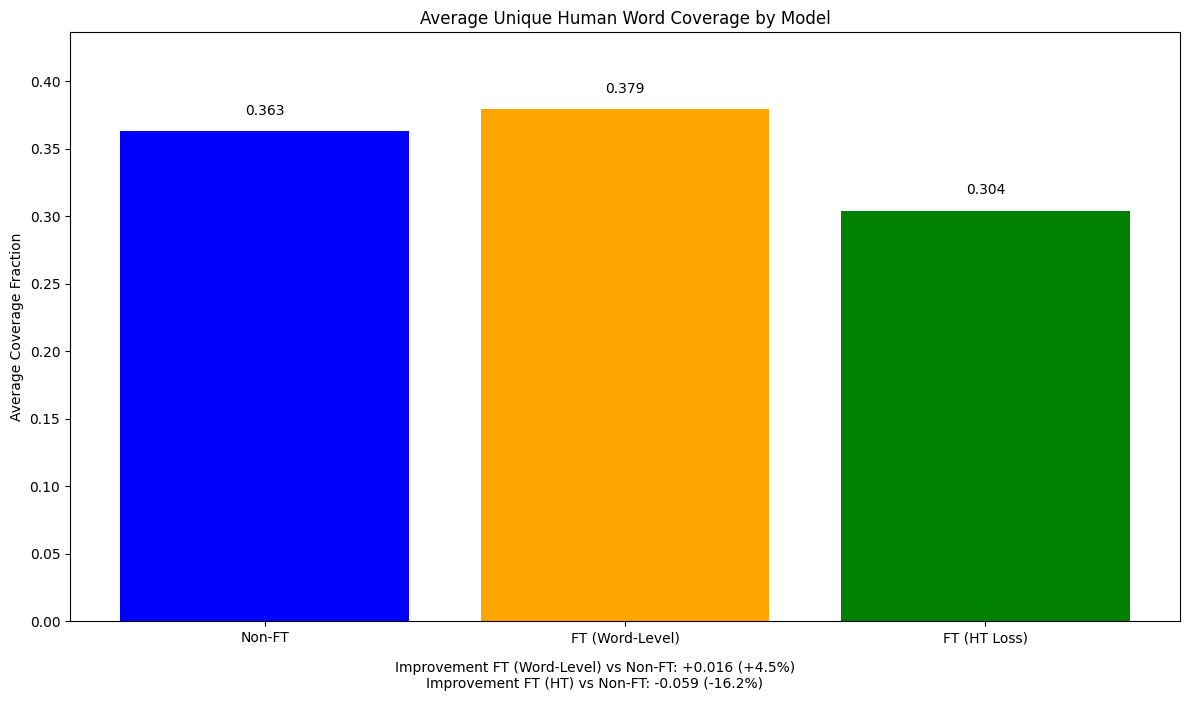

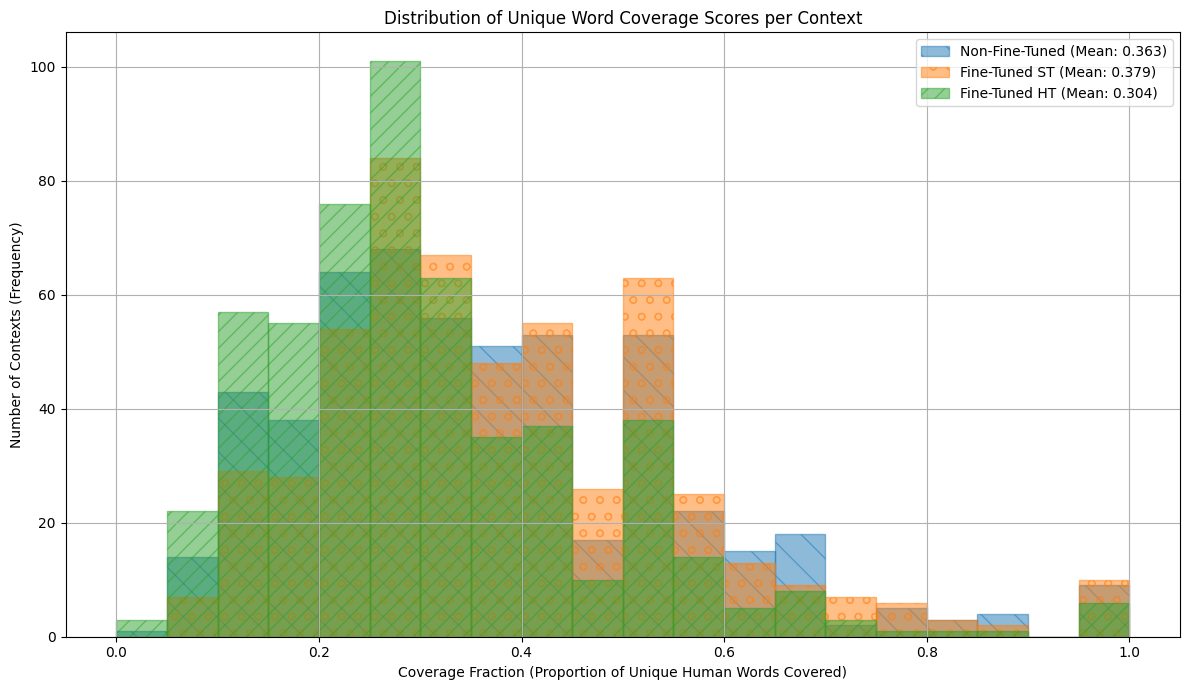

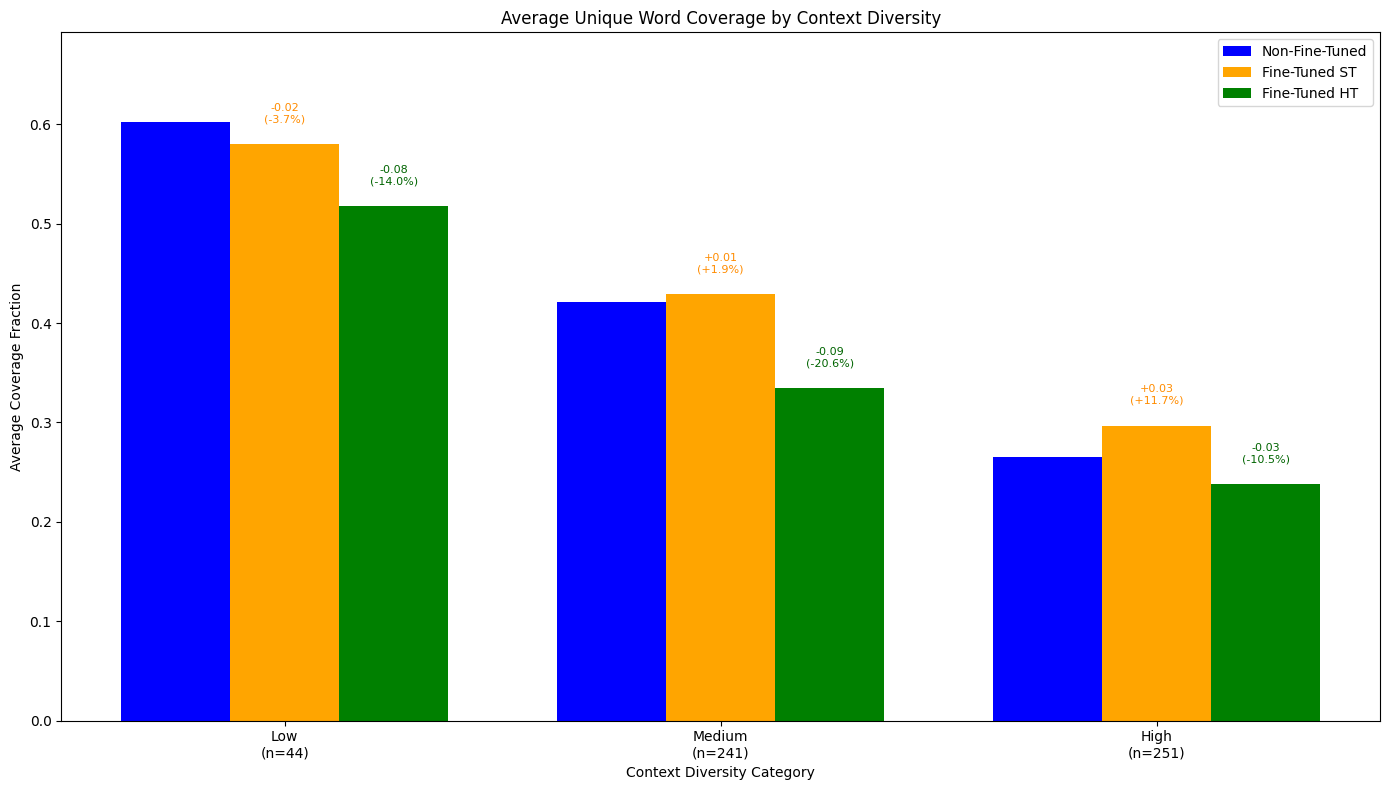

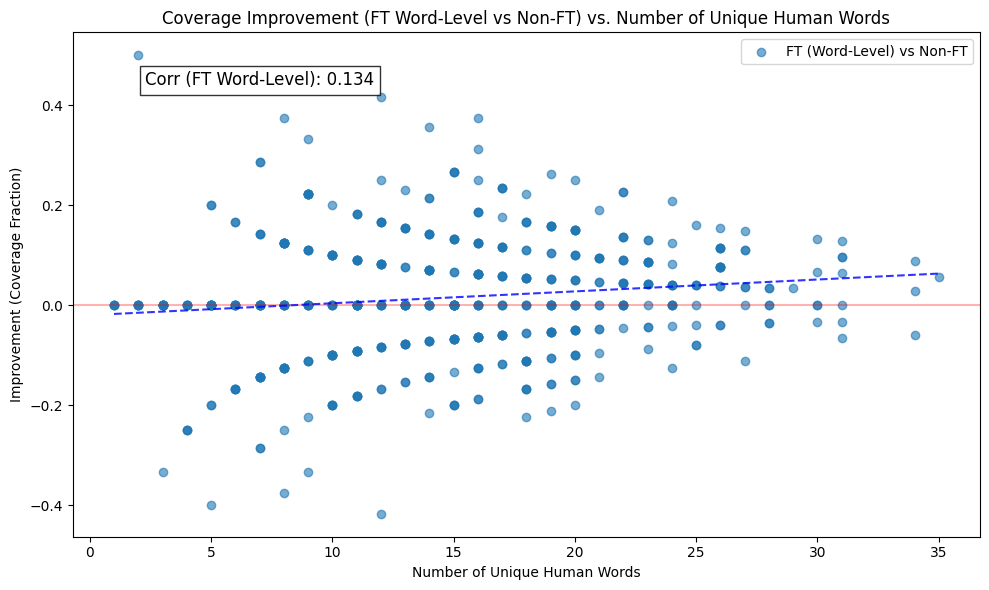

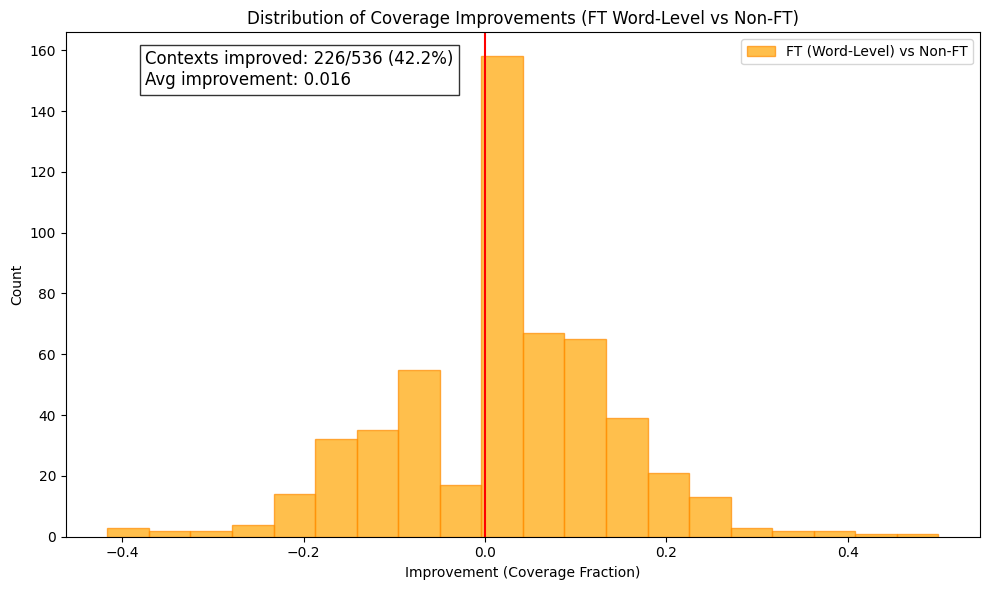

In [ ]:
def plot_word_coverage_results_ht_new(coverage_results):
    # 1. Overall coverage comparison (Bar Chart of Averages)
    labels_avg = ['Non-FT', 'FT (Word-Level)', 'FT (HT Loss)']
    avg_coverages = [
        coverage_results['avg_non_ft_coverage'],
        coverage_results['avg_ft_coverage'],
        coverage_results['avg_ft_ht_coverage']
    ]

    plt.figure(figsize=(12, 7))
    bars = plt.bar(labels_avg, avg_coverages, color=['blue', 'orange', 'green'])
    plt.title('Average Unique Human Word Coverage by Model')
    plt.ylabel('Average Coverage Fraction')
    plt.ylim(0, max(avg_coverages) * 1.15 if any(c > 0 for c in avg_coverages) else 1)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

    improvement_ft = coverage_results['avg_improvement_ft_vs_non_ft']
    improvement_ft_ht = coverage_results['avg_improvement_ft_ht_vs_non_ft']
    non_ft_cov_avg = coverage_results['avg_non_ft_coverage']
    percent_improvement_ft = (improvement_ft / non_ft_cov_avg * 100) if non_ft_cov_avg > 0 else 0
    percent_improvement_ft_ht = (improvement_ft_ht / non_ft_cov_avg * 100) if non_ft_cov_avg > 0 else 0
    figtext_str_avg = (f'Improvement FT (Word-Level) vs Non-FT: {improvement_ft:+.3f} ({percent_improvement_ft:+.1f}%)\n'
                       f'Improvement FT (HT) vs Non-FT: {improvement_ft_ht:+.3f} ({percent_improvement_ft_ht:+.1f}%)')
    plt.figtext(0.5, 0.01, figtext_str_avg, ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

    # 2. Distribution of Unique Word Coverage Scores (Histograms)
    non_ft_coverage_scores = [s for s in coverage_results.get('non_ft_coverage', []) if pd.notna(s)]
    ft_coverage_scores = [s for s in coverage_results.get('ft_coverage', []) if pd.notna(s)]
    ft_ht_coverage_scores = [s for s in coverage_results.get('ft_ht_coverage', []) if pd.notna(s)]

    # Calculate means for legend
    mean_non_ft_cov = np.mean(non_ft_coverage_scores) if non_ft_coverage_scores else np.nan
    mean_ft_cov = np.mean(ft_coverage_scores) if ft_coverage_scores else np.nan
    mean_ft_ht_cov = np.mean(ft_ht_coverage_scores) if ft_ht_coverage_scores else np.nan

    plt.figure(figsize=(12, 7))
    bins = np.linspace(0, 1, 21)

    color_non_ft = 'C0'
    color_ft_word = 'C1'
    color_ft_ht = 'C2'

    hatch_non_ft = '\\'
    hatch_ft_word = 'o'
    hatch_ft_ht = '//'

    alpha_val = 0.5

    plt.hist(non_ft_coverage_scores, bins=bins, alpha=alpha_val,
             label=f'Non-Fine-Tuned (Mean: {mean_non_ft_cov:.3f})' if pd.notna(mean_non_ft_cov) else 'Non-Fine-Tuned',
             color=color_non_ft, edgecolor=color_non_ft, hatch=hatch_non_ft)
    plt.hist(ft_coverage_scores, bins=bins, alpha=alpha_val,
             label=f'Fine-Tuned ST (Mean: {mean_ft_cov:.3f})' if pd.notna(mean_ft_cov) else 'Fine-Tuned ST',
             color=color_ft_word, edgecolor=color_ft_word, hatch=hatch_ft_word)
    plt.hist(ft_ht_coverage_scores, bins=bins, alpha=alpha_val,
             label=f'Fine-Tuned HT (Mean: {mean_ft_ht_cov:.3f})' if pd.notna(mean_ft_ht_cov) else 'Fine-Tuned HT',
             color=color_ft_ht, edgecolor=color_ft_ht, hatch=hatch_ft_ht)

    plt.title('Distribution of Unique Word Coverage Scores per Context')
    plt.xlabel('Coverage Fraction (Proportion of Unique Human Words Covered)')
    plt.ylabel('Number of Contexts (Frequency)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Coverage by diversity category
    if 'diversity_analysis' in coverage_results:
        categories_diversity = list(coverage_results['diversity_analysis'].keys())
        if categories_diversity:
            non_ft_by_category = [coverage_results['diversity_analysis'][cat]['avg_non_ft_coverage'] for cat in categories_diversity]
            ft_by_category = [coverage_results['diversity_analysis'][cat]['avg_ft_coverage'] for cat in categories_diversity]
            ft_ht_by_category = [coverage_results['diversity_analysis'][cat]['avg_ft_ht_coverage'] for cat in categories_diversity]
            counts_diversity = [coverage_results['diversity_analysis'][cat]['count'] for cat in categories_diversity]

            x_diversity = np.arange(len(categories_diversity))
            width_diversity = 0.25

            fig_diversity, ax_diversity = plt.subplots(figsize=(14, 8))
            rects1_div = ax_diversity.bar(x_diversity - width_diversity, non_ft_by_category, width_diversity, label='Non-Fine-Tuned', color='blue')
            rects2_div = ax_diversity.bar(x_diversity, ft_by_category, width_diversity, label='Fine-Tuned ST', color='orange')
            rects3_div = ax_diversity.bar(x_diversity + width_diversity, ft_ht_by_category, width_diversity, label='Fine-Tuned HT', color='green')

            ax_diversity.set_title('Average Unique Word Coverage by Context Diversity')
            ax_diversity.set_xlabel('Context Diversity Category')
            ax_diversity.set_ylabel('Average Coverage Fraction')
            ax_diversity.set_xticks(x_diversity)
            ax_diversity.set_xticklabels([f'{cat.title()}\n(n={counts_diversity[i]})' for i, cat in enumerate(categories_diversity)])
            ax_diversity.legend()
            all_cat_coverages_div = non_ft_by_category + ft_by_category + ft_ht_by_category
            ax_diversity.set_ylim(0, max(all_cat_coverages_div) * 1.15 if any(c > 0 for c in all_cat_coverages_div) else 1)

            for i, cat in enumerate(categories_diversity):
                imp_ft_vs_non_ft_cat = coverage_results['diversity_analysis'][cat]['avg_improvement_ft_vs_non_ft']
                base_cov_cat = non_ft_by_category[i]
                percent_imp_cat = (imp_ft_vs_non_ft_cat / base_cov_cat * 100) if base_cov_cat > 0 else 0
                ax_diversity.text(x_diversity[i], ft_by_category[i] + 0.02, f'{imp_ft_vs_non_ft_cat:+.2f}\n({percent_imp_cat:+.1f}%)',
                                  ha='center', va='bottom', color='darkorange', fontsize=8)

                imp_ht_vs_non_ft_cat = coverage_results['diversity_analysis'][cat]['avg_improvement_ft_ht_vs_non_ft']
                percent_imp_ht_cat = (imp_ht_vs_non_ft_cat / base_cov_cat * 100) if base_cov_cat > 0 else 0
                ax_diversity.text(x_diversity[i] + width_diversity, ft_ht_by_category[i] + 0.02, f'{imp_ht_vs_non_ft_cat:+.2f}\n({percent_imp_ht_cat:+.1f}%)',
                                  ha='center', va='bottom', color='darkgreen', fontsize=8)


            fig_diversity.tight_layout()
            plt.show()

    # 4. Scatter plot of improvement (FT Word-Level vs Non-FT) vs. number of unique human words
    improvements_ft_vs_non_ft_scatter = [ctx.get('improvement_ft_vs_non_ft', np.nan) for ctx in coverage_results['contexts']]
    unique_counts_scatter = [ctx.get('num_unique_human', np.nan) for ctx in coverage_results['contexts']]

    valid_scatter_indices = [i for i, (imp, uc) in enumerate(zip(improvements_ft_vs_non_ft_scatter, unique_counts_scatter)) if pd.notna(imp) and pd.notna(uc)]
    improvements_ft_vs_non_ft_scatter_valid = [improvements_ft_vs_non_ft_scatter[i] for i in valid_scatter_indices]
    unique_counts_scatter_valid = [unique_counts_scatter[i] for i in valid_scatter_indices]


    plt.figure(figsize=(10, 6))
    plt.scatter(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid, alpha=0.6, label='FT (Word-Level) vs Non-FT')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Coverage Improvement (FT Word-Level vs Non-FT) vs. Number of Unique Human Words')
    plt.xlabel('Number of Unique Human Words')
    plt.ylabel('Improvement (Coverage Fraction)')

    if unique_counts_scatter_valid and improvements_ft_vs_non_ft_scatter_valid and len(unique_counts_scatter_valid) > 1:
        z_scatter = np.polyfit(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid, 1)
        p_scatter = np.poly1d(z_scatter)
        sorted_unique_counts_scatter = sorted(unique_counts_scatter_valid)
        plt.plot(sorted_unique_counts_scatter, p_scatter(sorted_unique_counts_scatter), "--", alpha=0.8, color='blue')
        try:
            corr_scatter = np.corrcoef(unique_counts_scatter_valid, improvements_ft_vs_non_ft_scatter_valid)[0, 1]
            plt.figtext(0.15, 0.85, f'Corr (FT Word-Level): {corr_scatter:.3f}', fontsize=12,
                        bbox=dict(facecolor='white', alpha=0.8))
        except Exception as e:
            print(f"Could not compute correlation for scatter plot: {e}")

    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Histogram of improvements (FT Word-Level vs Non-FT)
    improvements_hist_valid = [s for s in improvements_ft_vs_non_ft_scatter if pd.notna(s)]

    plt.figure(figsize=(10, 6))
    if improvements_hist_valid:
        plt.hist(improvements_hist_valid, bins=20, alpha=0.7, color='orange', label='FT (Word-Level) vs Non-FT', edgecolor='darkorange')
        plt.axvline(x=0, color='r', linestyle='-')
        plt.title('Distribution of Coverage Improvements (FT Word-Level vs Non-FT)')
        plt.xlabel('Improvement (Coverage Fraction)')
        plt.ylabel('Count')

        positive_improvements_hist = [imp for imp in improvements_hist_valid if imp > 0]
        percent_improved_hist = len(positive_improvements_hist) / len(improvements_hist_valid) * 100 if improvements_hist_valid else 0
        plt.figtext(0.15, 0.85,
                   f'Contexts improved: {len(positive_improvements_hist)}/{len(improvements_hist_valid)} ({percent_improved_hist:.1f}%)\n'
                   f'Avg improvement: {np.mean(improvements_hist_valid):.3f}',
                   fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No improvement data to plot.", ha='center', va='center')
        plt.title('Distribution of Coverage Improvements (FT Word-Level vs Non-FT)')
        plt.xlabel('Improvement (Coverage Fraction)')
        plt.ylabel('Count')


    plt.tight_layout()
    plt.show()

plot_word_coverage_results_ht_new(coverage_results)

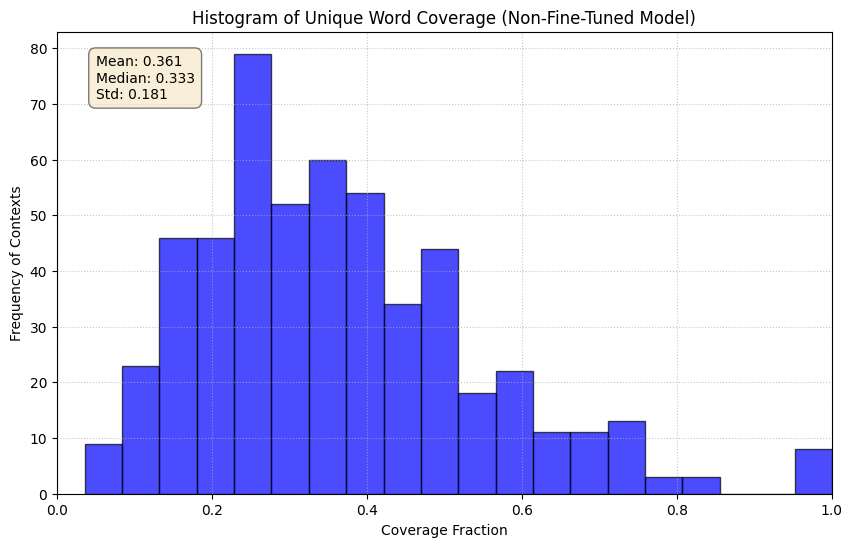

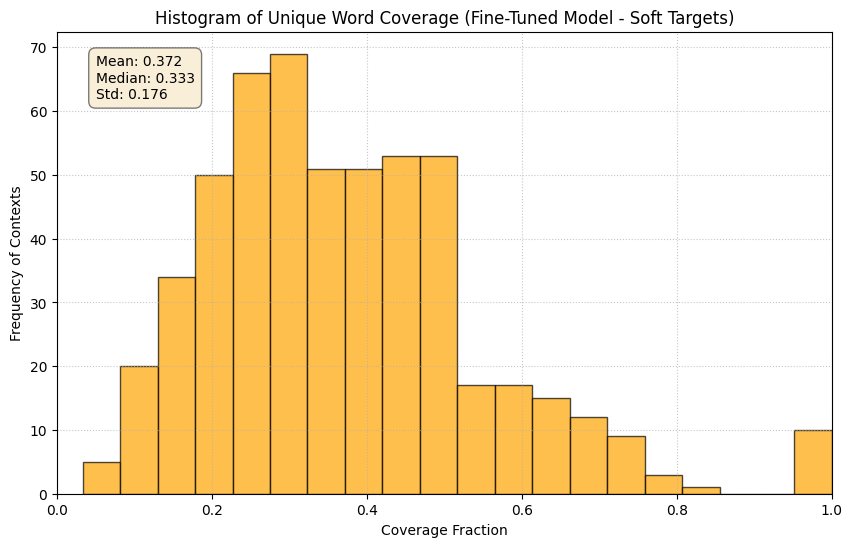

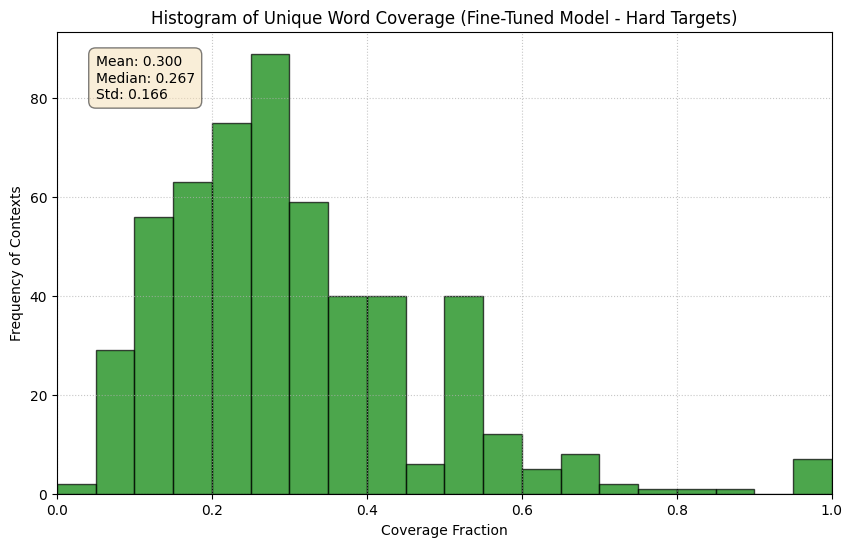

Histograms for unique word coverage displayed.
Number of contexts analyzed: 536
Average Non-FT Coverage: 0.361
Average FT (Word-Level) Coverage: 0.372
Average FT (CE) Coverage: 0.300


In [ ]:
# Plot the 3 histograms of unique word coverages seperately

# Extract coverage scores for each model
non_ft_coverages = [ctx['non_ft_coverage'] for ctx in coverage_results['contexts']]
ft_coverages = [ctx['ft_coverage'] for ctx in coverage_results['contexts']]
ft_ht_coverages = [ctx['ft_ht_coverage'] for ctx in coverage_results['contexts']]

# Plot for Non-Fine-Tuned Model
plt.figure(figsize=(10, 6))
plt.hist(non_ft_coverages, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Unique Word Coverage (Non-Fine-Tuned Model)')
plt.xlabel('Coverage Fraction')
plt.ylabel('Frequency of Contexts')
plt.xlim(0, 1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.text(0.05, 0.95, f"Mean: {np.mean(non_ft_coverages):.3f}\nMedian: {np.median(non_ft_coverages):.3f}\nStd: {np.std(non_ft_coverages):.3f}",
         transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.show()

# Plot for Fine-Tuned Model (Word-Level Loss)
plt.figure(figsize=(10, 6))
plt.hist(ft_coverages, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of Unique Word Coverage (Fine-Tuned Model - Soft Targets)')
plt.xlabel('Coverage Fraction')
plt.ylabel('Frequency of Contexts')
plt.xlim(0, 1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.text(0.05, 0.95, f"Mean: {np.mean(ft_coverages):.3f}\nMedian: {np.median(ft_coverages):.3f}\nStd: {np.std(ft_coverages):.3f}",
         transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.show()

# Plot for Fine-Tuned Model (HT Loss)
plt.figure(figsize=(10, 6))
plt.hist(ft_ht_coverages, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of Unique Word Coverage (Fine-Tuned Model - Hard Targets)')
plt.xlabel('Coverage Fraction')
plt.ylabel('Frequency of Contexts')
plt.xlim(0, 1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.text(0.05, 0.95, f"Mean: {np.mean(ft_ht_coverages):.3f}\nMedian: {np.median(ft_ht_coverages):.3f}\nStd: {np.std(ft_ht_coverages):.3f}",
         transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))
plt.show()

print("Histograms for unique word coverage displayed.")
print(f"Number of contexts analyzed: {len(coverage_results['contexts'])}")
print(f"Average Non-FT Coverage: {np.mean(non_ft_coverages):.3f}")
print(f"Average FT (Word-Level) Coverage: {np.mean(ft_coverages):.3f}")
print(f"Average FT (CE) Coverage: {np.mean(ft_ht_coverages):.3f}")

Test if the TVD mainly improves on contexts which where in the first place quite bad or if it improves geenrally across all contexts

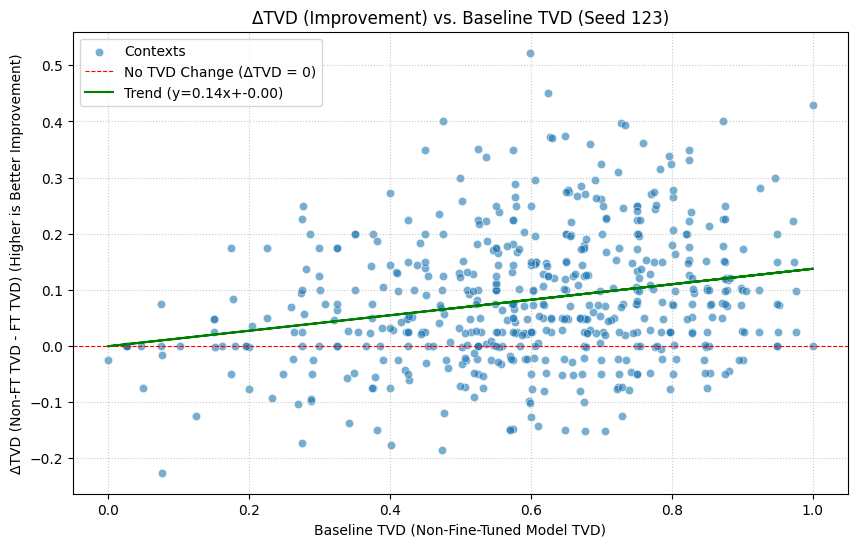

In [ ]:


def prepare_baseline_vs_delta_tvd_data(tvd_scores_non_ft_dict, tvd_scores_ft_dict, seed):
    """
    Prepares data for plotting baseline TVD vs. ΔTVD.

    Args:
        tvd_scores_non_ft_dict (dict): Dictionary mapping seed to list of non-FT TVD scores.
        tvd_scores_ft_dict (dict): Dictionary mapping seed to list of FT TVD scores.
        seed (int): The seed for which to prepare data.

    Returns:
        A list of tuples, where each tuple is (baseline_tvd, delta_tvd).
        Returns an empty list if data is insufficient or errors occur.
    """
    if seed not in tvd_scores_non_ft_dict or seed not in tvd_scores_ft_dict:
        print(f"Error: TVD scores for seed {seed} not found in one or both TVD score dictionaries.")
        return []

    baseline_tvds = np.array(tvd_scores_non_ft_dict[seed])
    ft_tvds = np.array(tvd_scores_ft_dict[seed])

    if len(baseline_tvds) != len(ft_tvds):
        print(f"Error: Mismatch in length of TVD score lists for seed {seed}.")
        return []

    if len(baseline_tvds) == 0:
        print(f"Warning: TVD score lists for seed {seed} are empty.")
        return []

    # Filter out NaNs
    valid_indices = ~ (np.isnan(baseline_tvds) | np.isnan(ft_tvds))

    valid_baseline_tvds = baseline_tvds[valid_indices]
    valid_ft_tvds = ft_tvds[valid_indices]

    if len(valid_baseline_tvds) == 0:
        print(f"Warning: No valid (non-NaN) TVD score pairs for seed {seed} after filtering.")
        return []

    delta_tvds = valid_baseline_tvds - valid_ft_tvds  # Improvement: non_ft - ft

    plot_data_points = list(zip(valid_baseline_tvds, delta_tvds))

    return plot_data_points

def plot_baseline_vs_delta_tvd(prepared_data, seed_value):
    """
    Plots baseline TVD (Non-FT TVD) vs. ΔTVD (TVD Improvement).

    Args:
        prepared_data: A list of (baseline_tvd, delta_tvd) tuples.
        seed_value: The seed for which the data was generated (for plot title).
    """
    if not prepared_data:
        print("No data to plot for baseline vs. ΔTVD.")
        return

    baseline_tvds = np.array([item[0] for item in prepared_data]) # X-axis
    delta_tvds = np.array([item[1] for item in prepared_data])    # Y-axis

    plt.figure(figsize=(10, 6))
    plt.scatter(baseline_tvds, delta_tvds, alpha=0.6, edgecolors='w', linewidth=0.5, label='Contexts')

    # Add a horizontal line at y=0 (no TVD change)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='No TVD Change (ΔTVD = 0)')

    # Optional: Add a regression line to visualize the trend
    if len(baseline_tvds) > 1: # Need at least 2 points for a line
        m, b = np.polyfit(baseline_tvds, delta_tvds, 1)
        plt.plot(baseline_tvds, m * baseline_tvds + b, color='green', linestyle='-', linewidth=1.5, label=f'Trend (y={m:.2f}x+{b:.2f})')

    plt.title(f'ΔTVD (Improvement) vs. Baseline TVD (Seed {seed_value})')
    plt.xlabel('Baseline TVD (Non-Fine-Tuned Model TVD)')
    plt.ylabel('ΔTVD (Non-FT TVD - FT TVD) (Higher is Better Improvement)')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()


seed_for_ceiling_floor_check = 123 # Or 42, or 456. Choose a seed that you have data for.

if 'tvd_scores_non_fine_tuned' in locals() and \
   'tvd_scores_fine_tuned' in locals():
    data_for_ceiling_plot = prepare_baseline_vs_delta_tvd_data(
        tvd_scores_non_fine_tuned,
        tvd_scores_fine_tuned,
        seed_for_ceiling_floor_check
    )
    if data_for_ceiling_plot:
        plot_baseline_vs_delta_tvd(data_for_ceiling_plot, seed_for_ceiling_floor_check)
    else:
        print(f"Could not generate data for ceiling/floor effect plot for seed {seed_for_ceiling_floor_check}.")
else:
    print("Please ensure 'tvd_scores_non_fine_tuned' and 'tvd_scores_fine_tuned' are defined.")


* The fine-tuning process appears to be effective overall, leading to TVD improvements for a large majority of contexts.
* The model shows greater improvement on "harder" contexts (those with higher baseline TVD). This is a positive finding, as it indicates the fine-tuning is making more substantial gains where they are most needed.
* There isn't a strong indication of a problematic "ceiling effect" where improvements are capped regardless of how bad the baseline is, nor a "floor effect" where improvements only occur for already good contexts. Instead, the improvement scales.
* While there are some contexts where performance degraded (points below ΔTVD = 0), they are in the minority.



# Ablation Study N Samples

In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def flatten_distribution_for_sampling(human_next_pred_list):
    """
    Flattens a list of (word, count) pairs into a list of words repeated by their count.
    Skips entries where word is not a string or count is not a positive number.
    """
    flat_list = []
    for word, count in human_next_pred_list:
        if isinstance(word, str) and isinstance(count, (int, float)) and count > 0:
            # Ensure word is not empty and count is positive integer
            word_stripped = word.strip()
            if word_stripped:
                try:
                    num_occurrences = int(round(count)) # Round if float, then int
                    if num_occurrences > 0:
                        flat_list.extend([word_stripped] * num_occurrences)
                except ValueError:
                    # print(f"Warning: Could not convert count '{count}' to int for word '{word_stripped}'. Skipping.")
                    pass # Skip if count is not convertible to int
        # else:
            # print(f"Warning: Invalid entry skipped in flatten_distribution: word='{word}', count='{count}'")
            pass
    return flat_list

def create_target_dist_from_n_samples(flat_list, n_s):
    """
    Samples n_s words (with replacement) from the flat_list and returns a new distribution
    in the format [(word, count_in_n_s_samples), ...].
    """
    if not flat_list or n_s == 0:
        return []

    sampled_words = random.choices(flat_list, k=n_s)

    word_counts_in_sample = Counter(sampled_words)
    new_distribution = []
    for word, count in word_counts_in_sample.items():
        new_distribution.append((word, count))
    return new_distribution

def prepare_data_for_n_sample_training(original_data_dict, n_samples_to_use):
    """
    Creates a new dataset where 'human_next_word_pred' for each sample
    is derived from N random samples from its original distribution.
    """
    modified_data = {}
    for key, sample_data_original in tqdm(original_data_dict.items(), desc=f"Preparing data (N={n_samples_to_use})"):
        new_sample = copy.deepcopy(sample_data_original)
        original_human_pred = new_sample.get('human_next_word_pred', [])

        flattened_preds = flatten_distribution_for_sampling(original_human_pred)

        if not flattened_preds:
            new_sample['human_next_word_pred'] = [] # word_level_loss should handle empty list
        else:
            new_target_dist = create_target_dist_from_n_samples(flattened_preds, n_samples_to_use)
            new_sample['human_next_word_pred'] = new_target_dist

        modified_data[key] = new_sample
    return modified_data


In [ ]:

# --- Ablation Study Parameters ---
sample_sizes_to_test = [1, 2, 4, 8, 16, 32]
ablation_study_results = {} # To store {'mean_tvd': ..., 'all_tvds': ...}

print("Starting Ablation Study: Number of Samples for Fine-Tuning")

# Check for prerequisite variables
try:
    _ = tokenizer
    _ = device
    _ = train_data
    _ = val_data
    _ = test_data
    tvd_scores_nft_seed123 = tvd_scores_non_fine_tuned[SEED]
    tvd_scores_oracle_seed123 = tvd_scores_oracle[SEED]
    _ = GPT2LMHeadModel
    _ = word_level_loss
    _ = train
    _ = evaluate_model_tvd
    _ = plot_tvd_scores_comparison
    _ = get_tvd_diff_and_dominant_percentage_data
    _ = plot_tvd_diff_vs_dominant_percentage
    _ = classify_contexts_by_consensus
    print("Prerequisite variables and functions seem to be available.")
except NameError as e:
    print(f"Error: A prerequisite variable or function is missing: {e}")
    print("Please ensure all required components are loaded/defined before running this ablation study.")
    # Stop execution if prerequisites are missing
    raise

# Main Ablation Loop
for n_s in sample_sizes_to_test:
    print(f"\n----- Processing for N_samples = {n_s} -----")

    # Re-initialize seed for deterministic model initialization and training for this N
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    # 1. Prepare training and validation data with N-sampled targets
    print(f"Preparing training data using {n_s} samples per context...")
    current_train_data_n_samples = prepare_data_for_n_sample_training(train_data, n_s)
    print(f"Preparing validation data using {n_s} samples per context...")
    current_val_data_n_samples = prepare_data_for_n_sample_training(val_data, n_s)

    # 2. Initialize a new GPT-2 model and optimizer
    print("Initializing new GPT-2 model...")
    model_n_samples = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    optimizer_n_samples = torch.optim.AdamW(model_n_samples.parameters(), lr=1e-5) # Consistent LR

    # 3. Fine-tune the model
    print("Starting fine-tuning...")
    # Assuming 'train' function is defined and handles epochs, mb_size internally or via defaults
    # Using 3 epochs as common in the notebook
    train_losses, val_losses = train(
        model_n_samples, optimizer_n_samples,
        current_train_data_n_samples, current_val_data_n_samples,
        tokenizer, device,
        soft_target=True, epochs=3, mb_size=16 # Match other training runs
    )
    print("Fine-tuning complete.")

    # 4. Evaluate the fine-tuned model on the original test_data
    print("Evaluating model on test_data...")
    # evaluate_model_tvd should use the original human distributions in test_data
    tvd_scores_for_n_s = evaluate_model_tvd(model_n_samples, tokenizer, test_data, device)

    # Calculate mean TVD, handling potential NaNs or Infs
    valid_tvd_scores = [s for s in tvd_scores_for_n_s if pd.notna(s) and np.isfinite(s)]
    mean_tvd_for_n_s = np.mean(valid_tvd_scores) if valid_tvd_scores else float('nan')
    print(f"Mean TVD for N_samples = {n_s}: {mean_tvd_for_n_s:.4f}")

    # 5. Store results (model object is not stored to save memory)
    ablation_study_results[n_s] = {
        'mean_tvd': mean_tvd_for_n_s,
        'all_tvds': tvd_scores_for_n_s
    }

print("\n--- Ablation Study Complete ---")
# Save results to a CSV file
results_df = pd.DataFrame.from_dict(ablation_study_results, orient='index')
results_df.index.name = 'N_samples'
results_df.to_csv('ablation_study_n_samples_results.csv')
print("Ablation study results saved to 'ablation_study_n_samples_results.csv'.")


Starting Ablation Study: Number of Samples for Fine-Tuning
Prerequisite variables and functions seem to be available.

----- Processing for N_samples = 1 -----
Preparing training data using 1 samples per context...


Preparing data (N=1): 100%|██████████| 1893/1893 [00:00<00:00, 14018.26it/s]


Preparing validation data using 1 samples per context...


Preparing data (N=1): 100%|██████████| 258/258 [00:00<00:00, 14291.40it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:14<00:00, 25.56it/s]


  → train_loss = 4.3344


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 80.41it/s]


  → val_loss   = 4.3451
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:12<00:00, 26.03it/s]


  → train_loss = 3.6984


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 77.00it/s]


  → val_loss   = 4.3215
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:12<00:00, 26.10it/s]


  → train_loss = 3.2938


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 66.04it/s]


  → val_loss   = 4.3696
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 1: 0.5608

----- Processing for N_samples = 2 -----
Preparing training data using 2 samples per context...


Preparing data (N=2): 100%|██████████| 1893/1893 [00:00<00:00, 15955.87it/s]


Preparing validation data using 2 samples per context...


Preparing data (N=2): 100%|██████████| 258/258 [00:00<00:00, 12729.60it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:15<00:00, 25.14it/s]


  → train_loss = 4.2572


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 76.20it/s]


  → val_loss   = 4.4505
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:14<00:00, 25.26it/s]


  → train_loss = 3.6840


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 77.07it/s]


  → val_loss   = 4.4120
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:14<00:00, 25.43it/s]


  → train_loss = 3.4114


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 76.28it/s]


  → val_loss   = 4.4255
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 2: 0.5663

----- Processing for N_samples = 4 -----
Preparing training data using 4 samples per context...


Preparing data (N=4): 100%|██████████| 1893/1893 [00:00<00:00, 16109.13it/s]


Preparing validation data using 4 samples per context...


Preparing data (N=4): 100%|██████████| 258/258 [00:00<00:00, 13120.87it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:17<00:00, 24.38it/s]


  → train_loss = 4.2388


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 72.71it/s]


  → val_loss   = 4.2924
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:17<00:00, 24.49it/s]


  → train_loss = 3.7508


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 74.45it/s]


  → val_loss   = 4.2703
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:17<00:00, 24.40it/s]


  → train_loss = 3.4990


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 69.61it/s]


  → val_loss   = 4.2833
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 4: 0.5568

----- Processing for N_samples = 8 -----
Preparing training data using 8 samples per context...


Preparing data (N=8): 100%|██████████| 1893/1893 [00:00<00:00, 15294.73it/s]


Preparing validation data using 8 samples per context...


Preparing data (N=8): 100%|██████████| 258/258 [00:00<00:00, 11826.05it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:21<00:00, 23.12it/s]


  → train_loss = 4.2068


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 59.51it/s]


  → val_loss   = 4.2094
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:21<00:00, 23.15it/s]


  → train_loss = 3.7718


  [ VAL ]: 100%|██████████| 258/258 [00:03<00:00, 69.23it/s]


  → val_loss   = 4.1641
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:22<00:00, 23.04it/s]


  → train_loss = 3.5546


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 60.16it/s]


  → val_loss   = 4.1654
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 8: 0.5543

----- Processing for N_samples = 16 -----
Preparing training data using 16 samples per context...


Preparing data (N=16): 100%|██████████| 1893/1893 [00:00<00:00, 15038.62it/s]


Preparing validation data using 16 samples per context...


Preparing data (N=16): 100%|██████████| 258/258 [00:00<00:00, 12627.55it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:27<00:00, 21.67it/s]


  → train_loss = 4.2167


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 62.58it/s]


  → val_loss   = 4.2411
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:27<00:00, 21.65it/s]


  → train_loss = 3.7880


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 63.33it/s]


  → val_loss   = 4.2015
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:27<00:00, 21.72it/s]


  → train_loss = 3.5959


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 62.19it/s]


  → val_loss   = 4.1846
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 16: 0.5508

----- Processing for N_samples = 32 -----
Preparing training data using 32 samples per context...


Preparing data (N=32): 100%|██████████| 1893/1893 [00:00<00:00, 14786.42it/s]


Preparing validation data using 32 samples per context...


Preparing data (N=32): 100%|██████████| 258/258 [00:00<00:00, 13879.52it/s]

Initializing new GPT-2 model...


Starting fine-tuning...
Epoch 1/3 


Epoch 1 [TRAIN]: 100%|██████████| 1893/1893 [01:32<00:00, 20.41it/s]


  → train_loss = 4.1722


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 55.09it/s]


  → val_loss   = 4.1796
Epoch 2/3 


Epoch 2 [TRAIN]: 100%|██████████| 1893/1893 [01:32<00:00, 20.39it/s]


  → train_loss = 3.7786


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 56.39it/s]


  → val_loss   = 4.1301
Epoch 3/3 


Epoch 3 [TRAIN]: 100%|██████████| 1893/1893 [01:32<00:00, 20.38it/s]


  → train_loss = 3.5915


  [ VAL ]: 100%|██████████| 258/258 [00:04<00:00, 51.74it/s]


  → val_loss   = 4.1211
Fine-tuning complete.
Evaluating model on test_data...
Mean TVD for N_samples = 32: 0.5509

--- Ablation Study Complete ---
Ablation study results saved to 'ablation_study_n_samples_results.csv'.
